Predictive modeling of Dow Jones Industrial Average

AAI 510 Machine Learning Fundamentals Section 02 Final Project, Team 3  
Reed Oken, Max Repupilli, Jamileh Jahangiry  
Prof. Wesley Pasfield  

Github repo:  
https://github.com/okenreed/AAI510_Final_Team3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install pandas-ta
import pandas_ta as ta
import yfinance as yf # pip install yfinance
import matplotlib.dates as mdates
from scipy import stats
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from prophet import Prophet


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Importing plotly failed. Interactive plots will not work.


Current 30 component stocks of the DJIA and an ETF index tracking the DJIA (DIA)

In [2]:
listings = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIA']

# Acquiring data from yfinance

This code will acquire the historical stock price and dividend information from the Yahoo Finance API and export it to CSV. This is also accomplished by data_collection.py within the repo.  
The code has been commented out as to not re-download old data, or to download new data.

In [3]:
#df = yf.download(tickers=listings, period='10y', interval='1d', auto_adjust=False)

In [4]:
"""
# stack and unstack indexed columns
df = df.stack(level=0).unstack(level=1)

# set each column name to TICKER - VALUE
df.columns = df.columns.map(lambda x: f'{x[0]} - {x[1]}')

# create date column from index
df = df.reset_index()
df = df.rename(columns={'index': 'Date'})
"""

"\n# stack and unstack indexed columns\ndf = df.stack(level=0).unstack(level=1)\n\n# set each column name to TICKER - VALUE\ndf.columns = df.columns.map(lambda x: f'{x[0]} - {x[1]}')\n\n# create date column from index\ndf = df.reset_index()\ndf = df.rename(columns={'index': 'Date'})\n"

In [5]:
"""
for ticker in listings:
    col_name = f'{ticker} - Dividend'
    div_series = yf.Ticker(ticker).dividends
    series_df = div_series.to_frame(name=col_name)
    series_df.index = series_df.index.tz_convert(None).floor('D')
    df = pd.merge(df, series_df, left_on='Date', right_index=True, how='left')
    df[col_name] = df[col_name].fillna(0)
"""

"\nfor ticker in listings:\n    col_name = f'{ticker} - Dividend'\n    div_series = yf.Ticker(ticker).dividends\n    series_df = div_series.to_frame(name=col_name)\n    series_df.index = series_df.index.tz_convert(None).floor('D')\n    df = pd.merge(df, series_df, left_on='Date', right_index=True, how='left')\n    df[col_name] = df[col_name].fillna(0)\n"

In [6]:
#df.to_csv('dija_w_divs.csv', index=False)

# Problem statement
The stock market is a key indicator of economic stability and a source of investment opportunities. Accurately predicting future trends in the stock market is a challenging and complex task that requires extensive data analysis and the use of advanced machine learning algorithms. The project goal is to analyze 20 years of DJIA and component stock data to build a model that can make accurate predictions about future trends in the market.
The project will utilize a variety of machine learning algorithms such as classification trees, time series analysis, and deep learning to train models on historical data and predict future market trends and stock performance.




# Data preparation and feature engineering

As stock market data is historically well maintained and widely available online, there is minimal data pre-processing that is required. Missing values are uncommon and do not appear within the stocks that are being addressed within the scopes of this project.  
However, stock market data is prime for feature engineering, including a wide range of different technical indicators which can be used to create new features for modeling from raw price and volume data.

In [7]:
os.chdir('C:/Users/Reed Oken\Documents/_MSAAI/AAI_510/Final/AAI510_Final_Team3/')
df = pd.read_csv('djia_data.csv')

## Feature engineering

**Technical indicators**  
The bulk of feature engineering is focused on using technical indicators to create new features from the raw historical stock market data. The primary technical indicators which will be investigated in this project are:  
Relative strength index (RSI) - A bounded (0-100) momentum indicator used in technical analysis that is useful for indicating whether a stock is over or undervalued. Two time periods will be used for calculating the RSI, 5 days and the industry standard 14 days.  
Exponential moving average (EMA) - An indicator giving more weight to recent prices than older prices. 3 time periods are used, 5, 15, and 50 days.  
Moving average convergence/divergence (MACD) - A trend indicator with three components involving the difference of moving averages over time periods (MACD), the moving average of the MACD (MACD signal), and the difference of the MACD and MACD signal (MACD divergence). Industry standard time periods are used, 26, 12, 9 days.  
Volume weighted average price (VWAP) - A weighting of the current stock price by its trading volume.

**Target Selection**  
Selecting a target for modeling involves selecting a time period for prediction of the stock market. In the modern world, instant news and rapidly changing world situations quickly effect the economy and predictions longer than a month are unlikely to be able to be relevant in this landscape. Targeting one week in the future, 5 periods, the stock market is able to have substantial change, without predictions being significantly skewed by external world events.  
For different models, different targets are needed. For regression models, the raw price will be calculated. For classification models, the models will instead classify the percent change that will occur over a week period as being positive or negative.

**Dividends**  
The raw data includes a stocks dividend as a 0 for every day a dividend is not paid and the dividend payment only on days it is paid. As this may be overly sparse, the feature will be re-engineered as a count down till the next day that a dividend is occuring for each stock.

In [8]:
def calculate_vwap(df_sC,df_sV):
    tp = (df_sC + df_sC.shift()) / 2
    vwap = (tp * df_sV).cumsum() / df_sV.cumsum()
    return vwap

In [9]:
for stock in listings:
    stock_df = pd.DataFrame()

    # TECHNICAL INDICATORS
    stock_df[f'{stock} - RSI14'] = ta.rsi(df[f'{stock} - Close'], length=14)
    stock_df[f'{stock} - RSI5'] = ta.rsi(df[f'{stock} - Close'], length=5)
    stock_df[f'{stock} - EMA5'] = ta.ema(df[f'{stock} - Close'], length=5)
    stock_df[f'{stock} - EMA15'] = ta.ema(df[f'{stock} - Close'], length=15)
    stock_df[f'{stock} - EMA50'] = ta.ema(df[f'{stock} - Close'], length=50)
    macd_short = ta.ema(df[f'{stock} - Close'], length=12)
    macd_long = ta.ema(df[f'{stock} - Close'], length=26)
    stock_df[f'{stock} - MACD'] = macd_short - macd_long
    stock_df[f'{stock} - MACD_signal'] = ta.ema(stock_df[f'{stock} - MACD'], length=9)
    stock_df[f'{stock} - MACD_div'] = stock_df[f'{stock} - MACD'] - stock_df[f'{stock} - MACD_signal']
    stock_df[f'{stock} - VWAP'] = calculate_vwap(df[f'{stock} - Close'], df[f'{stock} - Volume'])

    # TARGET ENGINEERING
    stock_df[f'{stock} - 1week_close'] = df[f'{stock} - Close'].shift(-5)
    stock_df[f'{stock} - Pct_change_wk'] = (stock_df[f'{stock} - 1week_close']/df[f'{stock} - Close'] - 1) * 100
    stock_df[f'{stock} - Wk_change_binary'] = stock_df[f'{stock} - Pct_change_wk'].apply(lambda x: 1 if x > 0 else 0)

    # Days till dividend
    stock_df[f'{stock} - Days_till_div'] = 0
    nonzero_div_indices = df[df[f'{stock} - Dividend'] != 0].index
    if(len(nonzero_div_indices) > 0):
        start_idx = 0
        end_idx = nonzero_div_indices[0]
        stock_df.loc[start_idx+1:end_idx, f'{stock} - Days_till_div'] = end_idx - df.index[start_idx:end_idx].values
        for i in range(len(nonzero_div_indices) - 1):
            start_idx = nonzero_div_indices[i]
            end_idx = nonzero_div_indices[i + 1]
            stock_df.loc[start_idx+1:end_idx, f'{stock} - Days_till_div'] = end_idx - df.index[start_idx:end_idx].values

    df = df.join(stock_df)

df = df.reindex()

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

## Cyclic encoding of dates  
The day of the week, day of the month, and month will all be cyclic encoded in order to retain the cyclic nature of these variables to the LSTM for modeling.  
The year will not be cyclic encoded as it is strictly increasing.

In [11]:
# extract int representation of date
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)
df['Weekday'] = df['Date'].dt.dayofweek.astype(int)

In [12]:
df.loc[:, 'Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 5)
df.loc[:, 'Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 5)

df.loc[:, 'Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df.loc[:, 'Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

df.loc[:, 'Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df.loc[:, 'Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [13]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

df_max = df.copy()

In [14]:
df_max['date'] = df_max['Date']
df_max['dayofweek'] = df_max['date'].dt.dayofweek
df_max['weekday'] = df_max['date'].dt.day_name()
df_max['weekday'] = df_max['weekday'].astype(cat_type)
df_max['quarter'] = df_max['date'].dt.quarter
df_max['month'] = df_max['date'].dt.month
df_max['year'] = df_max['date'].dt.year
df_max['dayofyear'] = df_max['date'].dt.dayofyear
df_max['dayofmonth'] = df_max['date'].dt.day
df_max['weekofyear'] = df_max['date'].dt.weekofyear
df_max['date_offset'] = (df_max.date.dt.month*100 + df_max.date.dt.day - 320)%1300
df_max['season'] = pd.cut(df_max['date_offset'], [0, 300, 602, 900, 1300],
                      labels=['Spring', 'Summer', 'Fall', 'Winter'])

In [15]:
X = df_max[['dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear','weekday',
        'season']]
y = df['MCD - Close']
features_and_target = pd.concat([X, y], axis=1)

# EDA

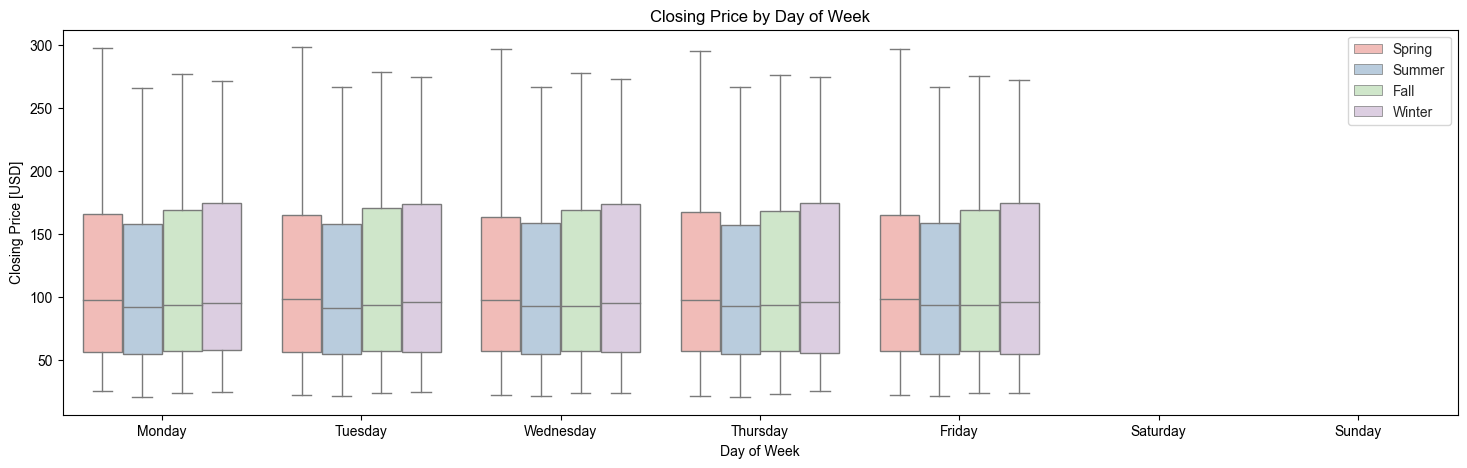

In [16]:
# BOXPLOTs will help visualize how some of these features relate to each other
fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='MCD - Close',
            hue='season',
            ax=ax,
            linewidth=1,
            palette="Pastel1")
# Remove the background color
sns.set_style("whitegrid")  # Set the style to "whitegrid" or "white"
ax.set_title('Closing Price by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Closing Price [USD]')
ax.legend(bbox_to_anchor=(1, 1))
plt.gca().patch.set_facecolor('none')  # Set the facecolor of the plot area to transparent
plt.show()

## Correlation

In [17]:
correlation_table = []

for stock in listings:
    target = f'{stock} - Pct_change_wk'
    cols = [col for col in df.columns if col.startswith(f'{stock} - ')]

    cols = cols + ['Weekday_sin', 'Weekday_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year']

    correlation_matrix = df[cols].corr()
    correlation_with_target = correlation_matrix[target].abs().sort_values(ascending=False)
    correlation_table.append(correlation_with_target)

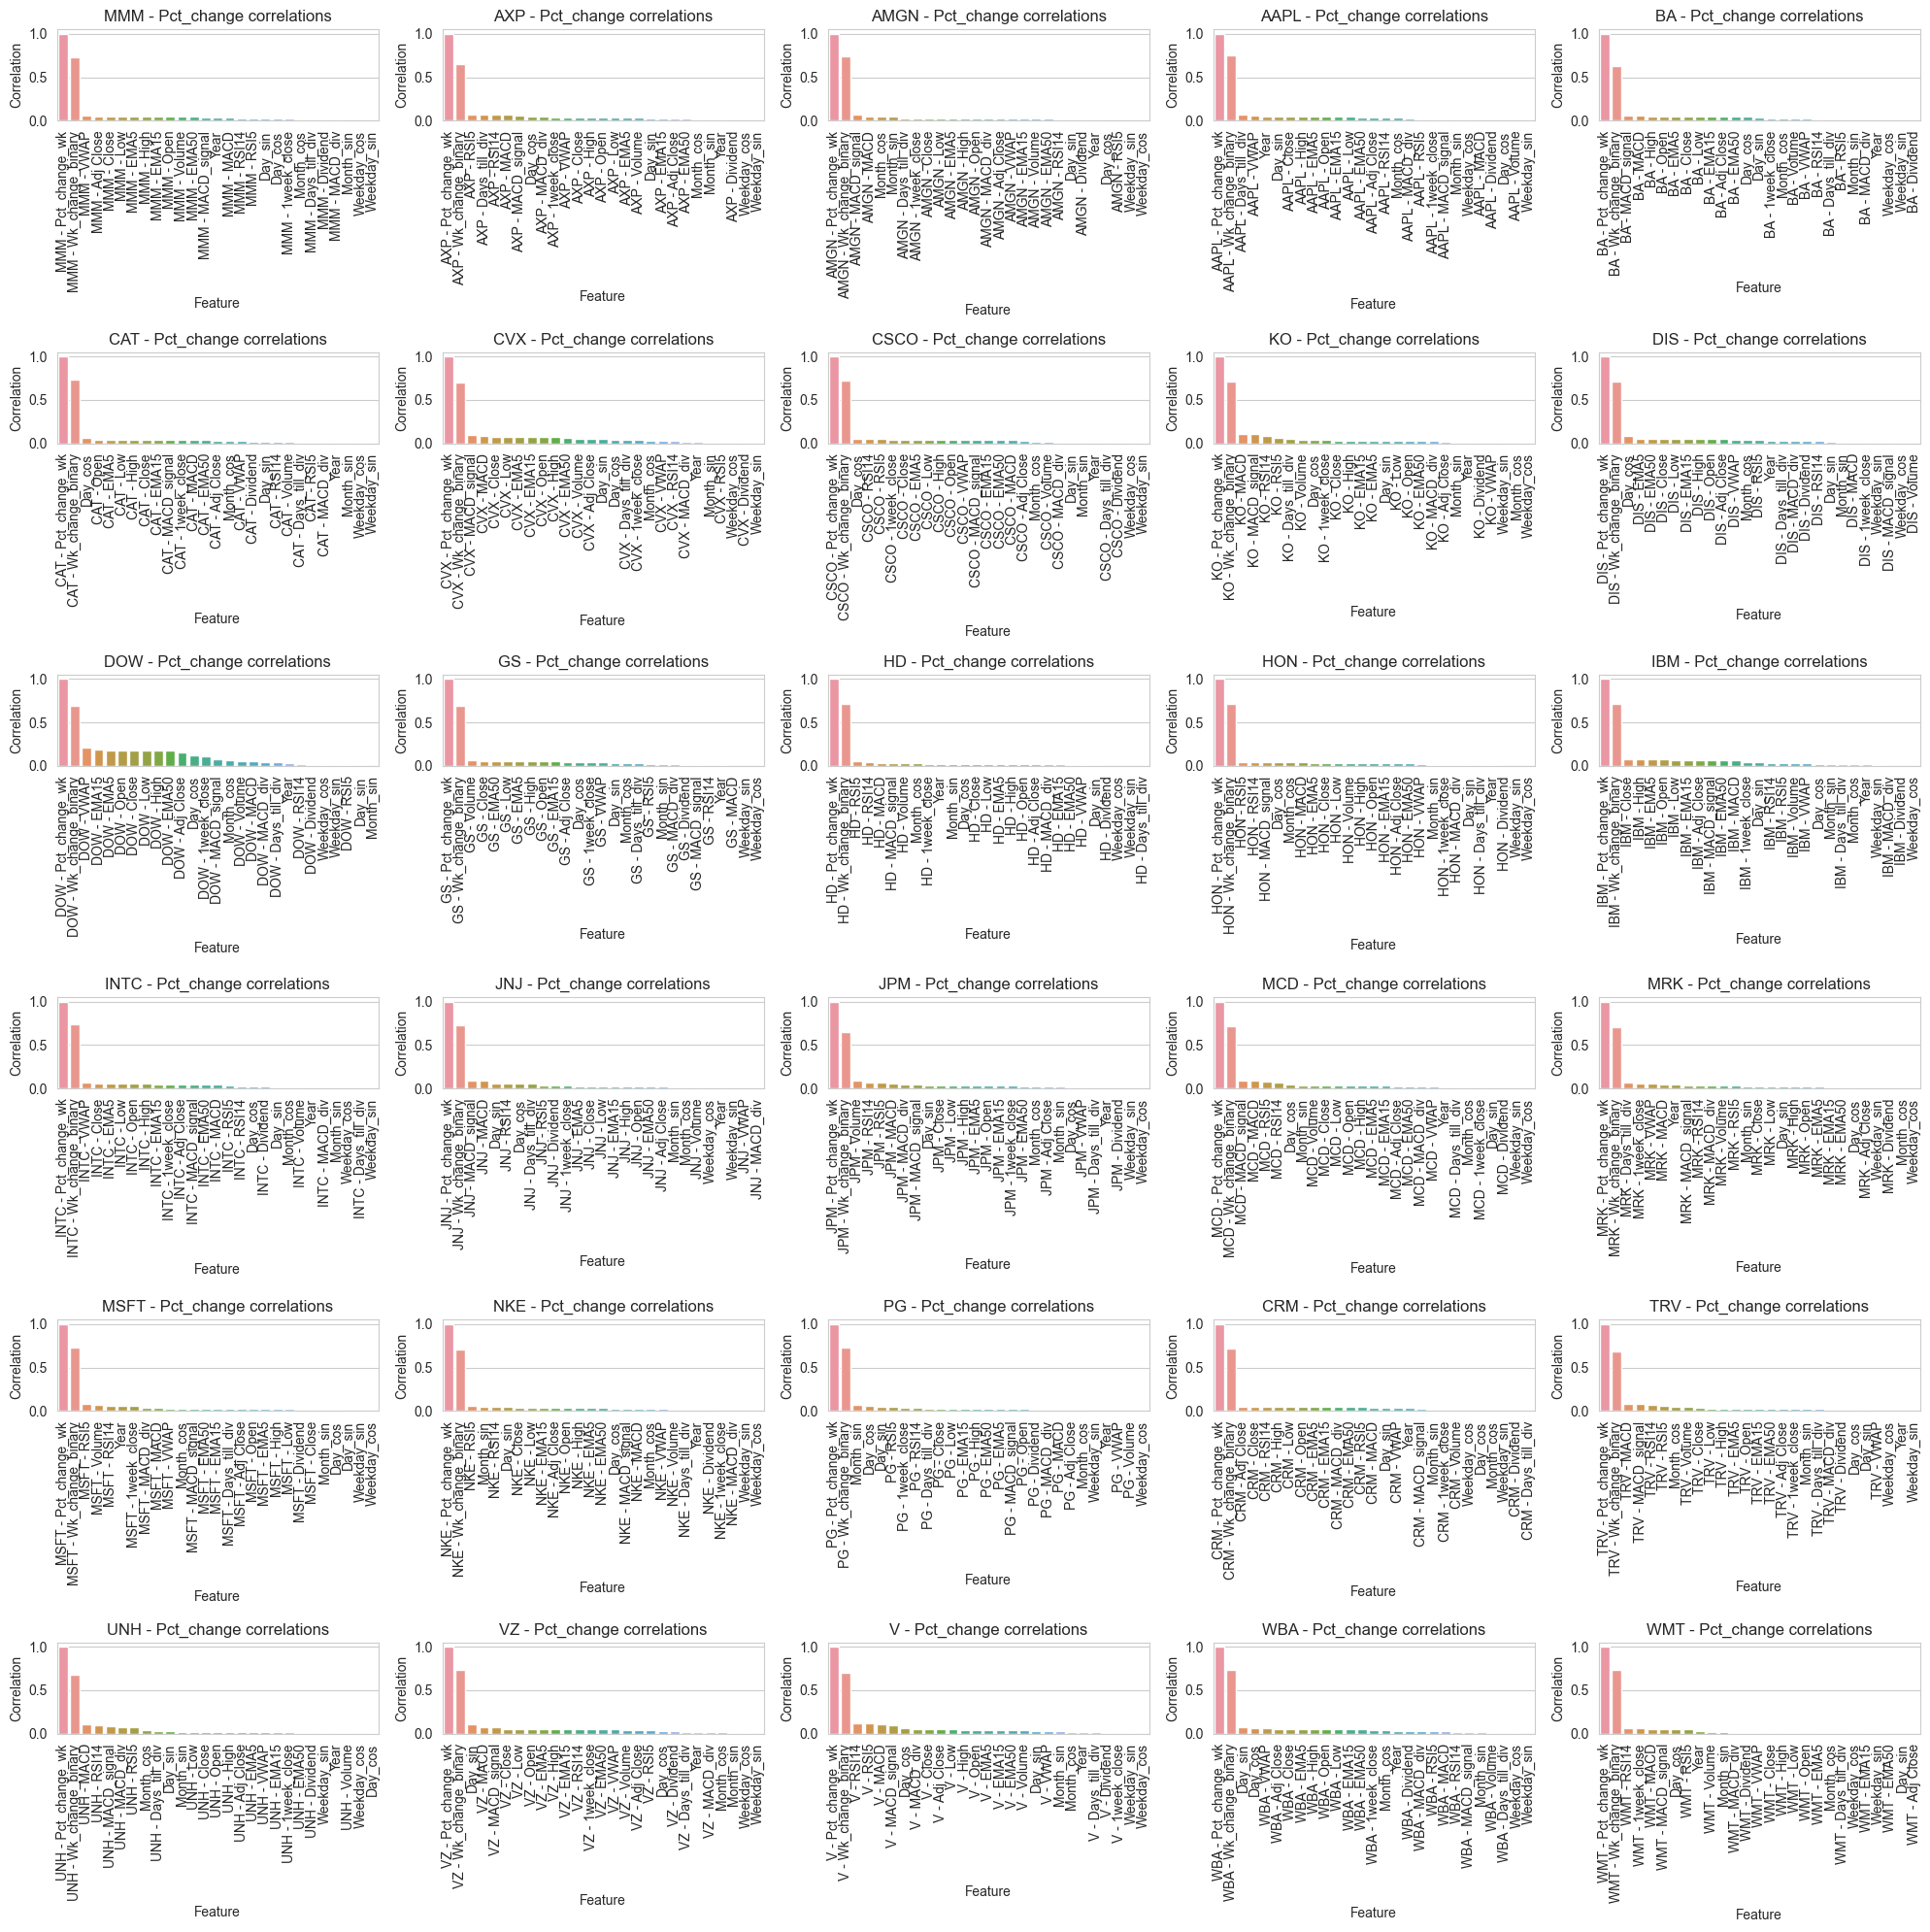

In [18]:
num_rows = 6
num_cols = 5

total_plots = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, stock in enumerate(listings[:total_plots]):
    target = f'{stock} - Pct_change'
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    sns.barplot(x=correlation_table[i].index, y=correlation_table[i].values, ax=ax)
    ax.set_title(f'{target} correlations')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Correlation')

    ax.tick_params(axis='x', rotation=90, size=4)

fig.tight_layout()

plt.show()

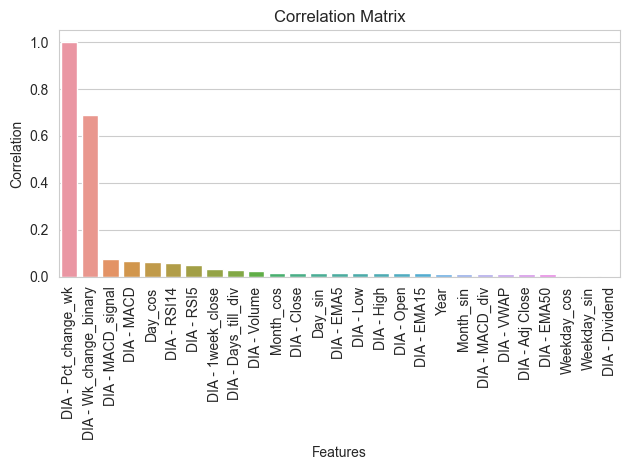

In [19]:
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## Plot of stock price over time

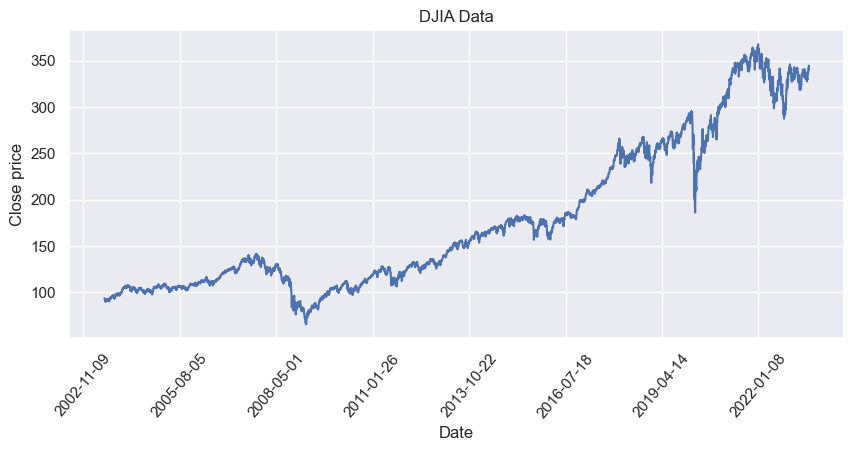

In [20]:
x = mdates.date2num(df['Date'])

sns.set(rc={'figure.figsize':(10, 4)})
sns.lineplot(x=x, y=df['DIA - Close'])

plt.title('DJIA Data')
plt.xlabel('Date')
plt.ylabel('Close price')

date_form = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_form)

plt.xticks(rotation=50)
plt.show()

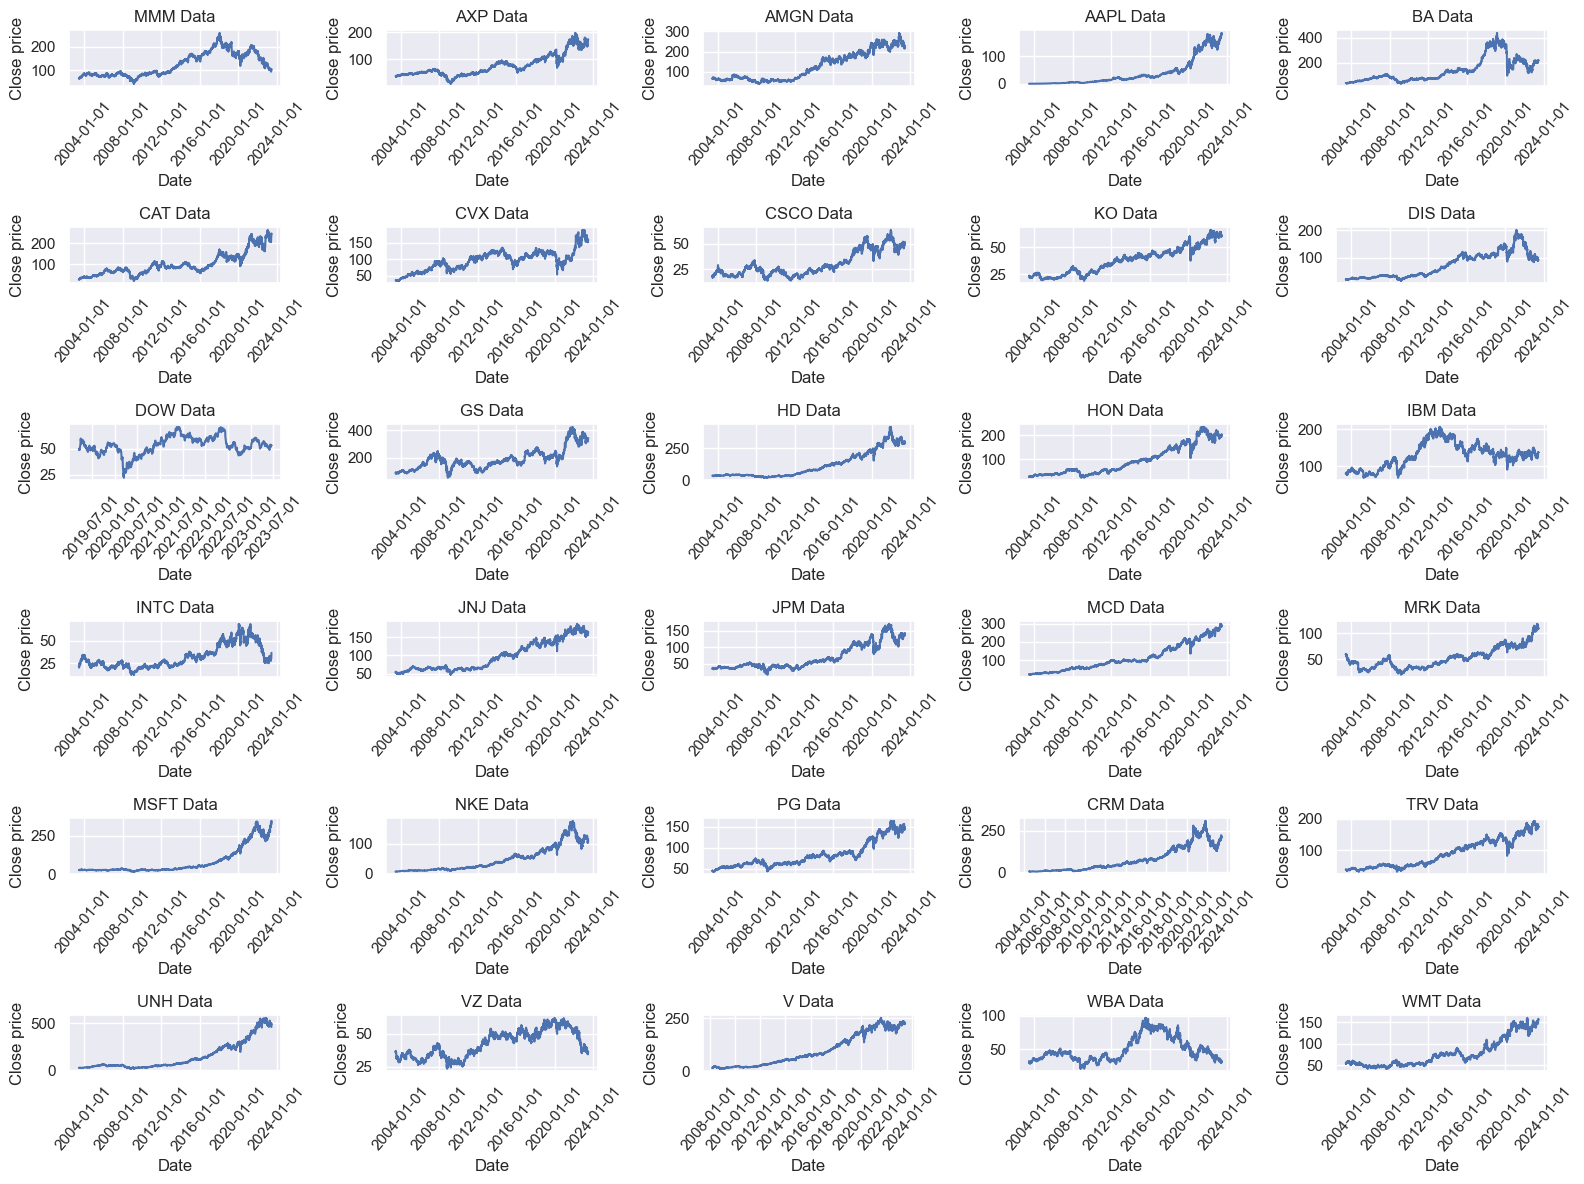

In [21]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

for i, stock in enumerate(listings[:total_plots]):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]

    sns.lineplot(x=x, y=df[f'{stock} - Close'], ax=ax)
    ax.set_title(f'{stock} Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close price')

    date_form = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', rotation=50)

fig.tight_layout()

plt.show()

## Weekly percent change histogram

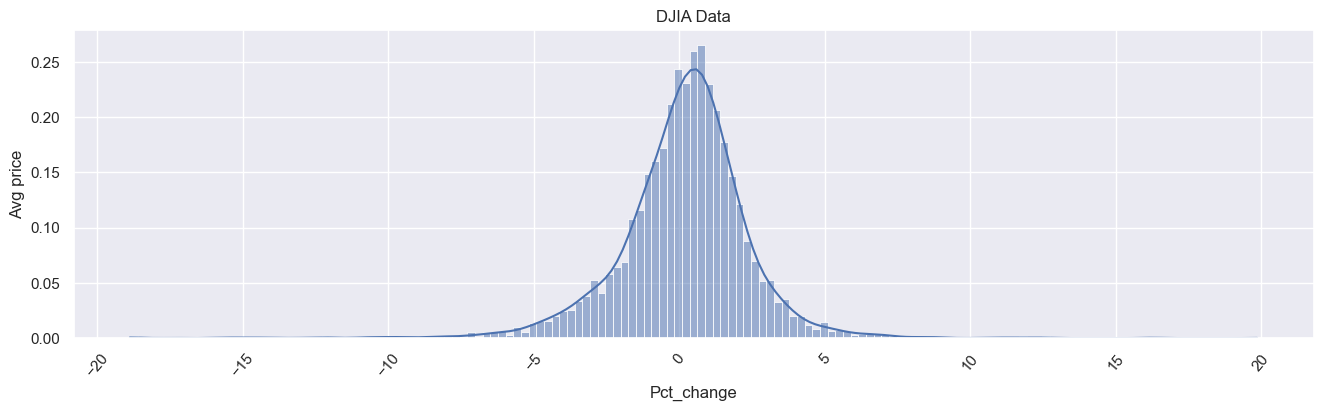

In [22]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.histplot(df['DIA - Pct_change_wk'], stat = 'density', kde=True)

plt.title('DJIA Data')
plt.xlabel('Pct_change')
plt.ylabel('Avg price')

plt.xticks(rotation=50)
plt.show()

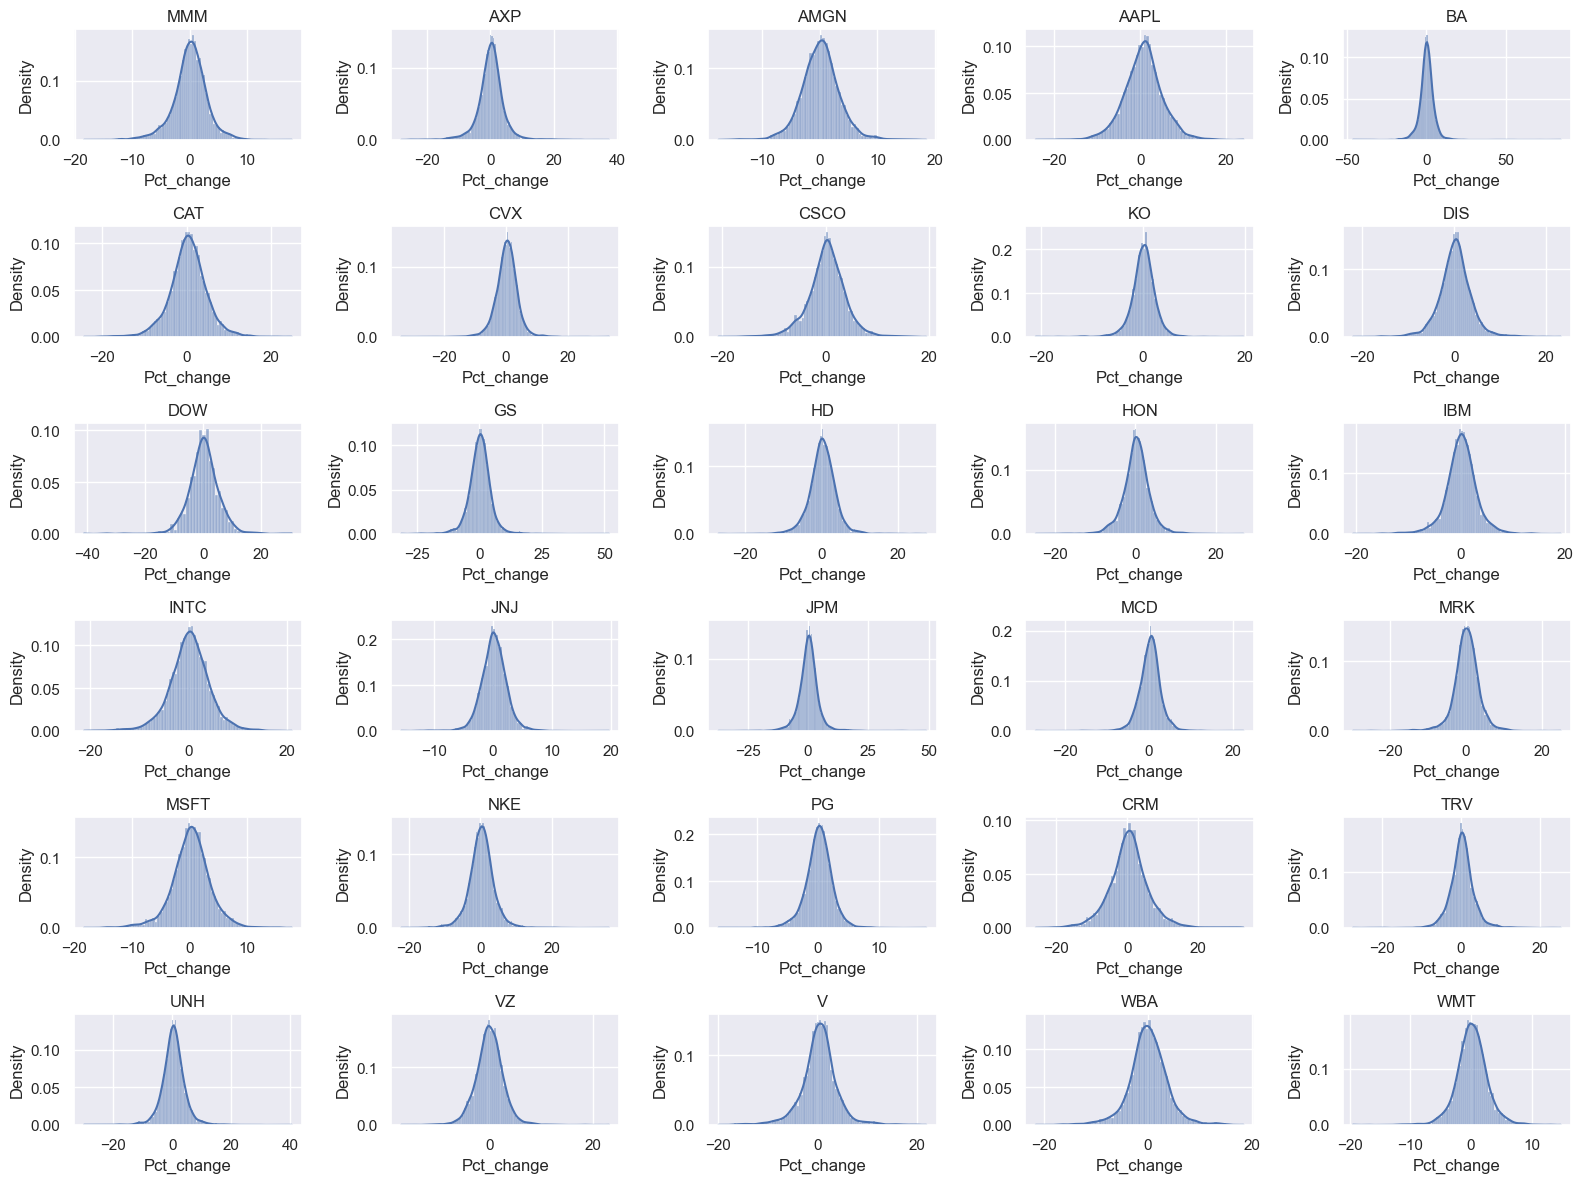

In [23]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

for i, stock in enumerate(listings[:total_plots]):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]

    sns.histplot(df[f'{stock} - Pct_change_wk'], stat='density', kde=True, ax=ax)
    ax.set_title(f'{stock}')
    ax.set_xlabel('Pct_change')
    ax.set_ylabel('Density')

fig.tight_layout()

plt.show()

## 14 Day RSI histogram

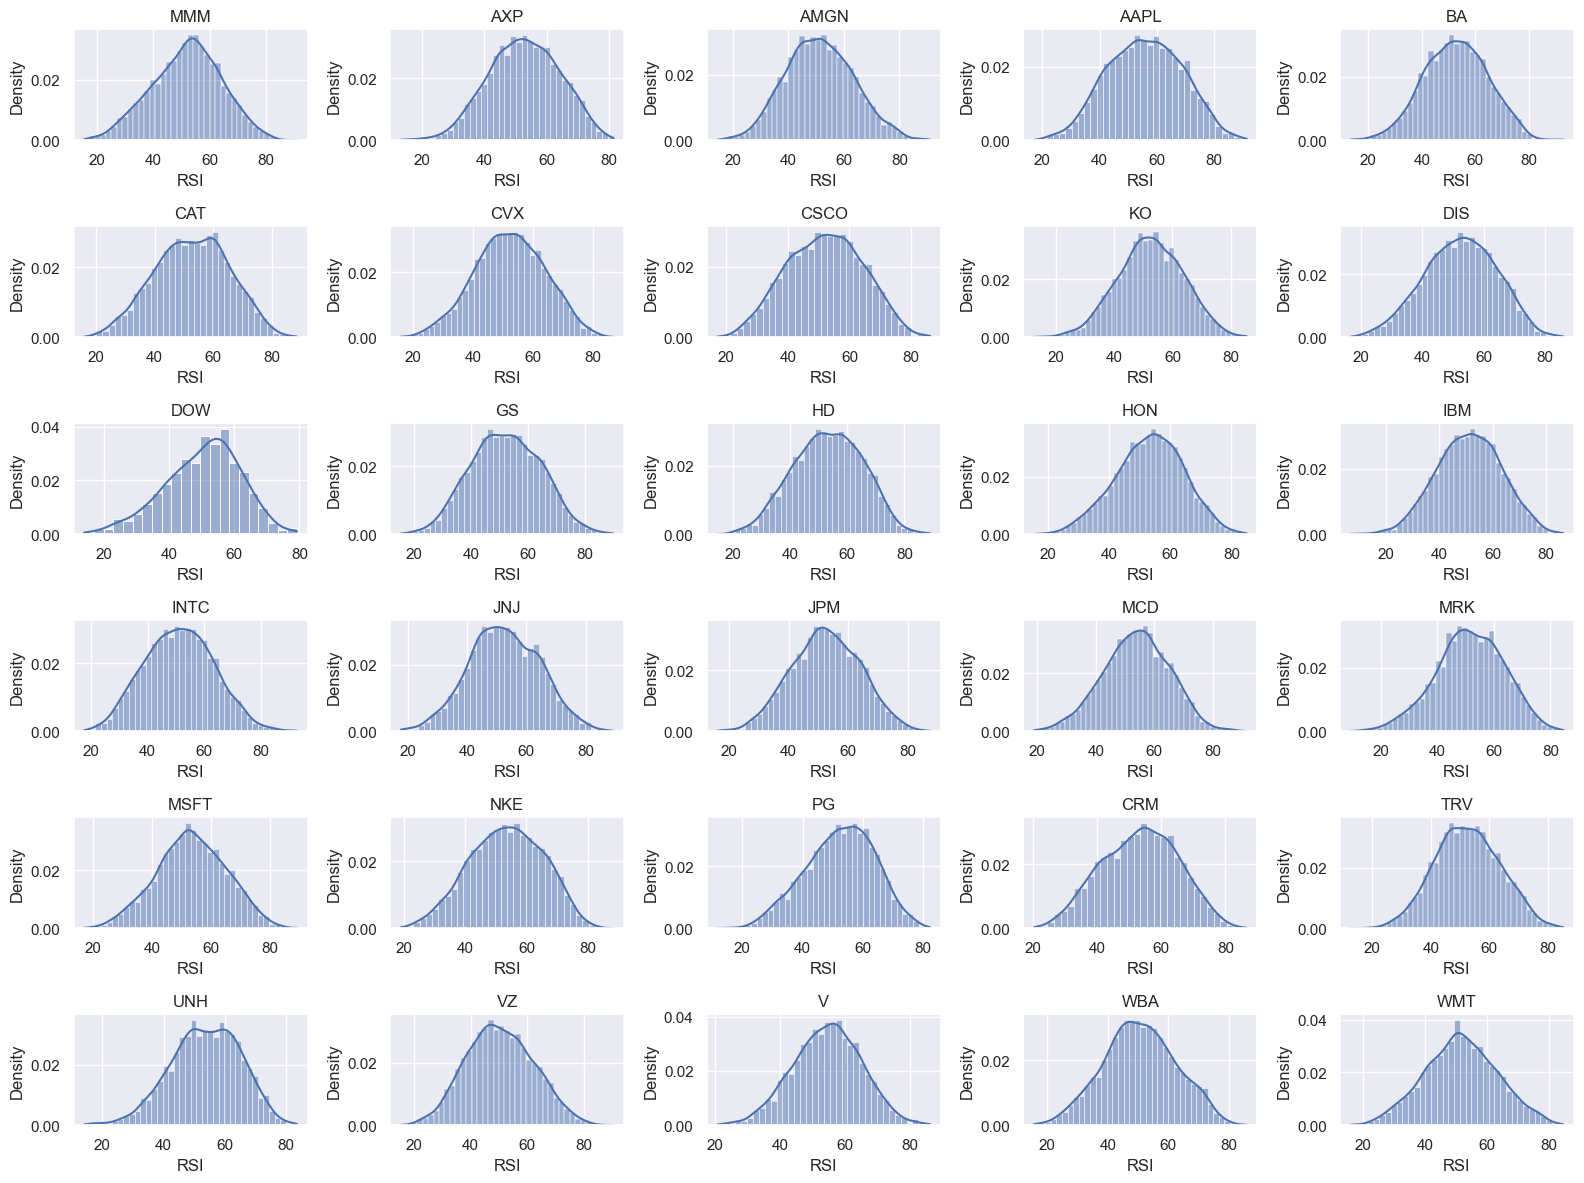

In [24]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

for i, stock in enumerate(listings[:total_plots]):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]

    sns.histplot(df[f'{stock} - RSI14'], stat='density', kde=True, ax=ax)
    ax.set_title(f'{stock}')
    ax.set_xlabel('RSI')
    ax.set_ylabel('Density')

fig.tight_layout()

plt.show()

## Feature selection

From the EDA, the most relevant features appear to be the technical indicators, along with the extracted date info, primarily month and day of the month. The cyclically encoded dates appear to have no correlation with the target and will be excluded from all models aside from the LSTM which is likely to gain the most benefit from the use of cylical encoding.  
As expected, the dividend has no predictive value, but the use of encoding the days till the next dividend does have a correlation which may be helpful in predictive modeling.

# Modeling

## LSTM - Regression

LSTM is a staple of time series predictive modeling and will be used to get a baseline performance for the regression task of predicting the stocks value in one week.

In [25]:
def rmse_calc(y_true, y_pred):
    """
    Function to calculate RMSE
    Inputs: y_true - True target values
            y_pred - Predicted target values
    Returns: RMSE
    """
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    """
    Function to calculate MAPE
    Inputs: y_true - True target values
            y_pred - Predicted target values
    Returns: MAPE
    """
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

In [26]:
def x_scaling(train, test, scaling_features):
    """
    Function to scale target features in training and testing dataset and recombine with unscaled features
    Inputs: train - Training dataset
            test - Testing dataset
            scaling_features - Features which will be scaled in the training and testing datasets
    Returns: train_scaled - Training dataset with desired features scaled
             test_scaled - Testing dataset with desired features fit to training scaling
    """
    scaler = MinMaxScaler()

    scaling_train_fts = train[scaling_features]
    scaling_test_fts = test[scaling_features]
    non_scaling_train = train.drop(columns = scaling_features)
    non_scaling_test = test.drop(columns = scaling_features)

    train_scaled = scaler.fit_transform(scaling_train_fts)
    test_scaled = scaler.transform(scaling_test_fts)

    train_scaled = np.concatenate((train_scaled, non_scaling_train), axis=1)
    test_scaled = np.concatenate((test_scaled, non_scaling_test), axis=1)

    return train_scaled, test_scaled

In [27]:
def train_test_split_time_series(x, y, size):
    """
    Function to create a train test split for time series data
    Inputs: x - Input features for model
            y - Target for model
            size - Percentage of dataset for training split
    Returns: x_train - Input features for training split
             x_test - Input features for testing split
             y_train - Target for training split
             y_test - Target for testing split
    """
    split = int(len(x)*size)
    y = y.values.reshape(-1,1)
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    return x_train, x_test, y_train, y_test

In [28]:
def sequencing(x_train, x_test, y_train, y_test, timesteps):
    """
    Function to create a sequence of features and targets for a time series prediction using LSTM
    Inputs: x_train - Input features for training dataset
            x_test - Input features for testing dataset
            y_train - Target for training dataset
            y_test - Target for testing dataset
            timesteps - The length of time for each sequence of features and targets
    Returns: x_train_lstm - Array of sequenced input training data
             x_test_lstm - Array of sequenced input testing data
             y_train_lstm - Array of sequenced target training data
             y_test_lstm - Array of sequenced target testing data
    """
    x_train_lstm = []
    x_test_lstm = []

    for i in range(x_train[0].size):
        x_train_lstm.append([])
        x_test_lstm.append([])
        for j in range(timesteps, x_train.shape[0]):
            x_train_lstm[i].append(x_train[j-timesteps:j, i])
        for j in range(timesteps, x_test.shape[0]):
            x_test_lstm[i].append(x_test[j-timesteps:j, i])

    x_train_lstm = np.moveaxis(x_train_lstm, [0], [2])
    x_test_lstm = np.moveaxis(x_test_lstm, [0], [2])

    y_train_lstm = np.array(y_train[timesteps:,-1])
    y_test_lstm = np.array(y_test[timesteps:,-1])

    y_train_lstm = y_train_lstm.reshape(len(y_train_lstm),1)
    y_test_lstm = y_test_lstm.reshape(len(y_test_lstm),1)

    return x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm

### Data setup

In [29]:
# identify stock of interest, features, and target
stock = 'DIA'
target = [f'{stock} - 1week_close']

# remove any nan rows existing in dataset due to creation of technical indicators
cols_to_check = [f'{stock} - EMA50'] + target
modeling_df = df.dropna(subset=cols_to_check)

cyclic_fts = ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Weekday_sin', 'Weekday_cos']
numerical_fts = [f'{stock} - Dividend', f'{stock} - Close', f'{stock} - Volume', 'Year', f'{stock} - RSI14', f'{stock} - RSI5', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50', f'{stock} - MACD', f'{stock} - MACD_signal']
all_fts = ['Date'] + cyclic_fts + numerical_fts

### Train test split

In [30]:
# train test split
x = modeling_df[all_fts]
y = modeling_df[target]

x_train, x_test, y_train, y_test = train_test_split_time_series(x, y, .8)

# store split dates for future plotting
train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop(columns=['Date'])
x_train = x_train.drop(columns=['Date'])

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)

# scale target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# sequence training and testing data
x_train_seq, x_test_seq, y_train_seq, y_test_seq = sequencing(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, 21)

# sequence dates of training and testing data
train_dates_seq = np.array(train_dates[21:])
test_dates_seq = np.array(test_dates[21:])

### Modeling

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('32_nodes.h5', monitor='val_loss', save_best_only=True)
model = Sequential()
model.add(LSTM(32, input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_seq, y_train_seq, epochs=1000, batch_size=32, validation_data=(x_test_seq, y_test_seq), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000
124/124 - 2s - loss: 0.0275 - val_loss: 0.0582 - 2s/epoch - 17ms/step
Epoch 2/1000
124/124 - 0s - loss: 0.0133 - val_loss: 0.0506 - 480ms/epoch - 4ms/step
Epoch 3/1000
124/124 - 0s - loss: 0.0085 - val_loss: 0.0480 - 477ms/epoch - 4ms/step
Epoch 4/1000
124/124 - 0s - loss: 0.0068 - val_loss: 0.0557 - 466ms/epoch - 4ms/step
Epoch 5/1000
124/124 - 0s - loss: 0.0054 - val_loss: 0.0544 - 470ms/epoch - 4ms/step
Epoch 6/1000
124/124 - 0s - loss: 0.0050 - val_loss: 0.0602 - 472ms/epoch - 4ms/step
Epoch 7/1000
124/124 - 0s - loss: 0.0047 - val_loss: 0.0739 - 469ms/epoch - 4ms/step
Epoch 8/1000
124/124 - 0s - loss: 0.0043 - val_loss: 0.0614 - 469ms/epoch - 4ms/step
Epoch 9/1000
124/124 - 0s - loss: 0.0044 - val_loss: 0.0665 - 480ms/epoch - 4ms/step
Epoch 10/1000
124/124 - 1s - loss: 0.0041 - val_loss: 0.0556 - 550ms/epoch - 4ms/step
Epoch 11/1000
124/124 - 1s - loss: 0.0039 - val_loss: 0.0575 - 516ms/epoch - 4ms/step
Epoch 12/1000
124/124 - 1s - loss: 0.0036 - val_loss: 0.0640 - 52

In [32]:
best_model = load_model('32_nodes.h5')
y_pred = best_model.predict(x_test_seq)

31/31 [==============================] - 0s 2ms/step


In [33]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

mse = np.mean((y_pred_inv - y_test_inv)**2)

print('LSTM Scores')
print(f'MSE:  {mse:.3f}')
print(f'MAE:  {mean_absolute_error(y_test_inv, y_pred_inv):.3f}')
print(f'RMSE: {rmse_calc(y_test_inv, y_pred_inv):.3f}')
print(f'MAPE: {mape_calc(y_test_inv, y_pred_inv):.3f}')

LSTM Scores
MSE:  1970.092
MAE:  38.196
RMSE: 44.386
MAPE: 0.118


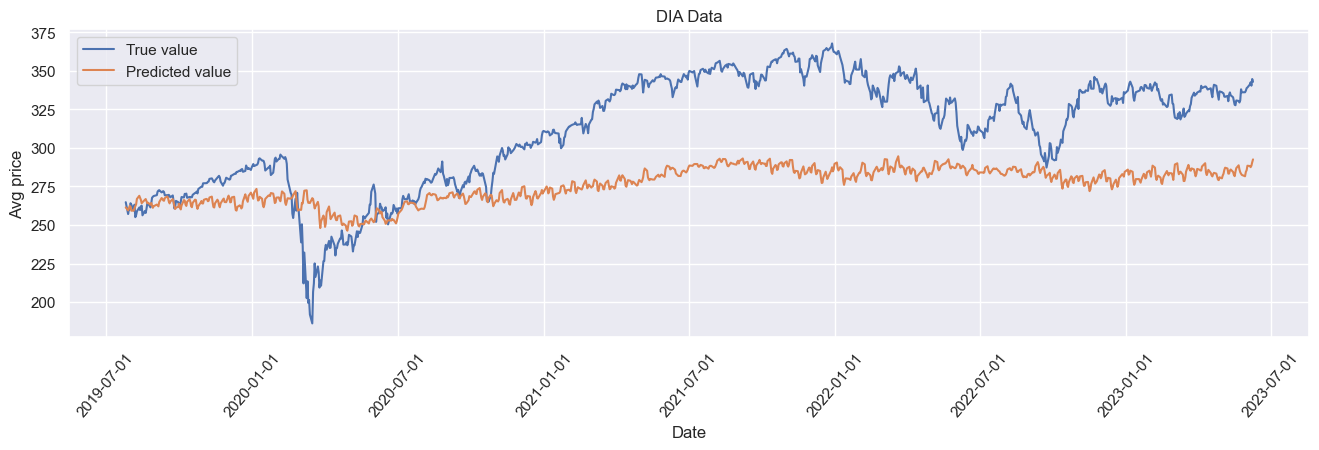

In [34]:
x = mdates.date2num(test_dates_seq)

sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=x, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=x, y=y_pred_inv.flatten(), label=f'Predicted value')

plt.title(f'{stock} Data')
plt.xlabel('Date')
plt.ylabel('Avg price')


date_form = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=50)
plt.show()

## LSTM Binary Classification, single stock



In addition to using LSTM for regression, LSTMs can also be useful for classification tasks. LSTM will be used for creating a baseline for the classification task of predicting whether a stock will have a positive or negative price change over the next week.

In [35]:
# identify stock of interest, features, and target
stock = 'DIA'
target = [f'{stock} - Wk_change_binary']

# remove any nan rows existing in dataset due to creation of technical indicators
cols_to_check = [f'{stock} - EMA50'] + target
modeling_df = df.dropna(subset=cols_to_check)

numerical_fts = [f'{stock} - Days_till_div', f'{stock} - Close', f'{stock} - Volume', 'Year', f'{stock} - RSI5', f'{stock} - RSI14', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50']
all_fts = ['Date', 'Day', 'Month'] + numerical_fts

### Train test split

In [36]:
# train test split
x = modeling_df[all_fts]
y = modeling_df[target]

x_train, x_test, y_train, y_test = train_test_split_time_series(x, y, .8)

# store split dates for future plotting
train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop(columns=['Date'])
x_train = x_train.drop(columns=['Date'])

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)

# sequence training and testing data
x_train_seq, x_test_seq, y_train_seq, y_test_seq = sequencing(x_train_scaled, x_test_scaled, y_train, y_test, 21)

# sequence dates of training and testing data
train_dates_seq = np.array(train_dates[21:])
test_dates_seq = np.array(test_dates[21:])

### Modeling

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('classification.h5', monitor='val_loss', save_best_only=True)

model = Sequential()
model.add(LSTM(32, input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), AUC()])

history = model.fit(x_train_seq, y_train_seq, epochs=1000, batch_size=32, validation_data=(x_test_seq, y_test_seq), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000
124/124 - 2s - loss: 0.7009 - accuracy: 0.5514 - precision: 0.5768 - recall: 0.8386 - auc: 0.4859 - val_loss: 0.6907 - val_accuracy: 0.5711 - val_precision: 0.5711 - val_recall: 1.0000 - val_auc: 0.4689 - 2s/epoch - 20ms/step
Epoch 2/1000
124/124 - 0s - loss: 0.6934 - accuracy: 0.5519 - precision: 0.5737 - recall: 0.8726 - auc: 0.4861 - val_loss: 0.6902 - val_accuracy: 0.5711 - val_precision: 0.5711 - val_recall: 1.0000 - val_auc: 0.4395 - 452ms/epoch - 4ms/step
Epoch 3/1000
124/124 - 0s - loss: 0.6885 - accuracy: 0.5678 - precision: 0.5788 - recall: 0.9250 - auc: 0.4925 - val_loss: 0.6889 - val_accuracy: 0.5711 - val_precision: 0.5711 - val_recall: 1.0000 - val_auc: 0.4589 - 413ms/epoch - 3ms/step
Epoch 4/1000
124/124 - 0s - loss: 0.6867 - accuracy: 0.5670 - precision: 0.5768 - recall: 0.9402 - auc: 0.4974 - val_loss: 0.6905 - val_accuracy: 0.5711 - val_precision: 0.5711 - val_recall: 1.0000 - val_auc: 0.4478 - 412ms/epoch - 3ms/step
Epoch 5/1000
124/124 - 0s - loss: 0.68

In [38]:
loss, accuracy, precision, recall, auc = model.evaluate(x_test_seq, y_test_seq)

31/31 [==============================] - 0s 2ms/step - loss: 0.7073 - accuracy: 0.5455 - precision: 0.5628 - recall: 0.9158 - auc: 0.4447


In [39]:
metrics = {
        'Model': 'LSTM',
        'Stock': 'DIA',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': '-',
        'AUC': auc
    }

# df to store perf metrics thru rest of nb
metrics_df = pd.DataFrame()

metrics_df = metrics_df.append(metrics, ignore_index=True)

In [40]:
def perf_metrics(y_test, y_pred, model, dataset):
    """Function to calculate and return performance metrics"""
    metrics = {
        'Model': model,
        'Stock': dataset,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }
    return metrics

## Tree models

While not typically used for time series data, trees are highly interpretable, and can be highly predictive provided the correct features are provided to the models. While a tree will not be able to capture the same temporal dependencies that an LSTM or other time series based model will be able to, classification trees will still be able to make accurate predictions for any given day, based on well engineered features. By inputting the extracted date information and technical indicators, which capture historical and current trend information about a stock, these tree methods could be an effective tool for predicting how a stock will behave over a timeframe.

### Decision tree Binary Classification, single stock

In [41]:
dt = DecisionTreeClassifier()
dt = dt.fit(x_train_scaled, y_train)

In [42]:
# predict on classifier
y_pred = dt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'DT', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

### GBT Binary Classification, single stock

In [43]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
# predict on classifier
y_pred = gbt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'GBT', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

### RF Binary Classification, single stock

In [45]:
# create and fit RF
rf = RandomForestClassifier()
rf = rf.fit(x_train_scaled, y_train)

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_18760\3149677526.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(x_train_scaled, y_train)


In [46]:
# predict on classifier
y_pred = rf.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'RF', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

## SVM Binary Classification, single stock

In [47]:
svm = SVC()
svm = svm.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
y_pred = svm.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'SVM', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [49]:
importances = gbt.feature_importances_
fn = x_train.columns

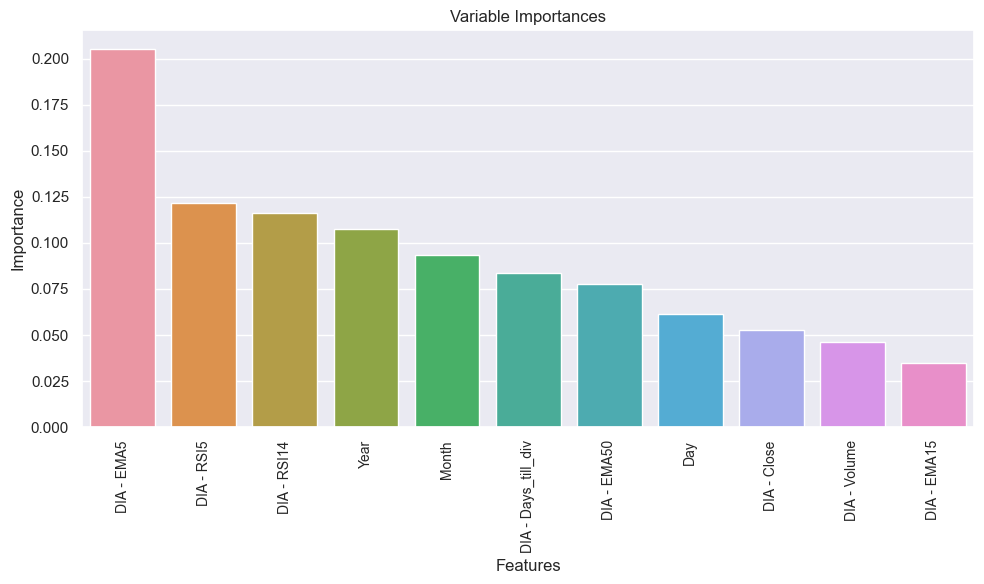

In [50]:
# sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in indices]
sorted_fn = [fn[idx] for idx in indices]

# plot the variable importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_fn, y=sorted_importances)
plt.title("Variable Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

In [51]:
metrics_df

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
0,LSTM,DIA,0.545548,0.562775,0.915771,-,0.444737
1,DT,DIA,0.565130,0.569647,0.964789,0.71634,0.500999
2,GBT,DIA,0.566132,0.570681,0.959507,0.715693,0.503009
3,RF,DIA,0.491984,0.664865,0.216549,0.326693,0.536182
4,SVM,DIA,0.569138,0.569138,1.000000,0.725415,0.500000


## All stocks in one binary classification model

Training a model on a single stock may have highly predictive results for that individual stock, but a model which is able to capture trends within the entire market could be far more useful as it would be significantly more generalizable.  
With that in mind, stock names will be removed from the dataframe, providing signficantly more samples for training and testing the classification models. While some stocks which performed exceptionally well when modeled individually may do slightly worse, the general model will ideally be able to predict stock movements far more generally.

In [52]:
test_df = df.copy()

In [53]:
combined_df = pd.DataFrame()

for stock in listings:
    temp_df = pd.DataFrame()
    stock_cols = [col for col in test_df.columns if col.startswith(f'{stock} -')]
    for col in stock_cols:
        new_col_name = col.replace(f'{stock} - ', '')
        temp_df[new_col_name] = test_df[col]
    universal_cols = [col for col in test_df.columns if '-' not in col]
    temp_df[universal_cols] = test_df[universal_cols]
    combined_df = pd.concat([temp_df, combined_df], ignore_index=True)

In [54]:
combined_df = combined_df.dropna()

In [55]:
combined_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Dividend',
       'RSI14', 'RSI5', 'EMA5', 'EMA15', 'EMA50', 'MACD', 'MACD_signal',
       'MACD_div', 'VWAP', '1week_close', 'Pct_change_wk', 'Wk_change_binary',
       'Days_till_div', 'Date', 'Year', 'Month', 'Day', 'Weekday',
       'Weekday_sin', 'Weekday_cos', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos'],
      dtype='object')

In [56]:
# identify stock of interest, features, and target
target = ['Wk_change_binary']

numerical_fts = ['Days_till_div', 'Close', 'Volume', 'RSI5', 'RSI14', 'EMA5', 'EMA15', 'EMA50', 'MACD', 'MACD_signal']
all_fts = ['Day', 'Month', 'Year'] + numerical_fts

In [57]:
len(combined_df)

149128

In [58]:
len(combined_df[combined_df['Date'] > '2021-06-30'])

15159

In [59]:
train_end_date = '2021-07-01'

In [60]:
training_df = combined_df.drop(combined_df[combined_df['Date'] >= train_end_date].index)
testing_df = combined_df.drop(combined_df[combined_df['Date'] < train_end_date].index)

In [61]:
# train test split
x = training_df[all_fts]
y = training_df[target]

x_test = testing_df[all_fts]
y_test = testing_df[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.1)

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)
x_train_scaled, x_val_scaled = x_scaling(x_train, x_val, numerical_fts)

## DT Binary Classification, all stocks

In [62]:
dt = DecisionTreeClassifier()
dt = dt.fit(x_train_scaled, y_train)

In [63]:
# predict on classifier
y_pred = dt.predict(x_val_scaled)

metrics = perf_metrics(y_val, y_pred, 'DT', 'All')
metrics_df = metrics_df.append(metrics, ignore_index=True)

## GBT, Binary Classification, all stocks

In [64]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
# predict on classifier
y_pred = gbt.predict(x_val_scaled)

metrics = perf_metrics(y_val, y_pred, 'GBT', 'All')
metrics_df = metrics_df.append(metrics, ignore_index=True)

## RF Binary Classification, all stocks

In [66]:
# create and fit RF
rf = RandomForestClassifier()
rf = rf.fit(x_train_scaled, y_train)

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_18760\3149677526.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(x_train_scaled, y_train)


In [67]:
# predict on classifier
y_pred = rf.predict(x_val_scaled)

metrics = perf_metrics(y_val, y_pred, 'RF', 'All')
metrics_df = metrics_df.append(metrics, ignore_index=True)

## SVM Binary Classification, all stocks

In [68]:
svm = SVC()
svm = svm.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
y_pred = svm.predict(x_val_scaled)

metrics = perf_metrics(y_val, y_pred, 'SVM', 'All')
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [70]:
importances = rf.feature_importances_
fn = x_train.columns

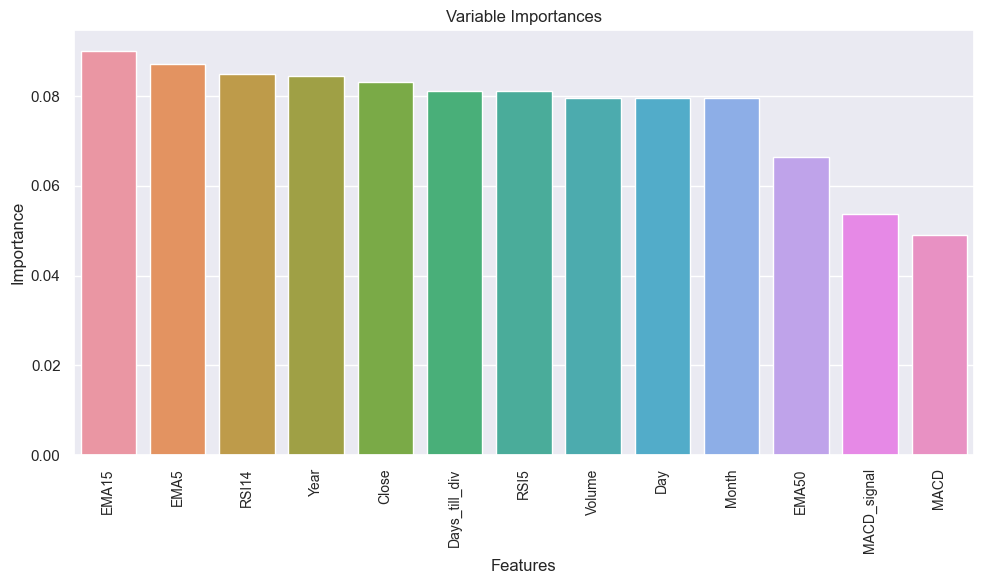

In [71]:
# sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in indices]
sorted_fn = [fn[idx] for idx in indices]

# plot the variable importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_fn, y=sorted_importances)
plt.title("Variable Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

In [72]:
dia_df = df.drop(df[df['Date'] < train_end_date].index)

# identify stock of interest, features, and target
stock = 'DIA'
target = [f'{stock} - Wk_change_binary']

# remove any nan rows existing in dataset due to creation of technical indicators
cols_to_check = [f'{stock} - EMA50'] + target
dia_df = dia_df.dropna(subset=cols_to_check)


numerical_fts = [f'{stock} - Days_till_div', f'{stock} - Close', f'{stock} - Volume', f'{stock} - RSI5', f'{stock} - RSI14', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50', f'{stock} - MACD', f'{stock} - MACD_signal']
all_fts = ['Day', 'Month', 'Year'] + numerical_fts

In [73]:
x_test = dia_df[all_fts]
y_test = dia_df[target]

In [74]:
for col in numerical_fts:
    x_test = x_test.rename(columns={col: col.replace(f'{stock} - ', '')})

numerical_fts = ['Days_till_div', 'Close', 'Volume', 'RSI5', 'RSI14', 'EMA5', 'EMA15', 'EMA50', 'MACD', 'MACD_signal']

In [75]:
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)

In [76]:
# predict on classifier
y_pred = rf.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'RF', 'DIA')
metrics_df = metrics_df.append(metrics, ignore_index=True)

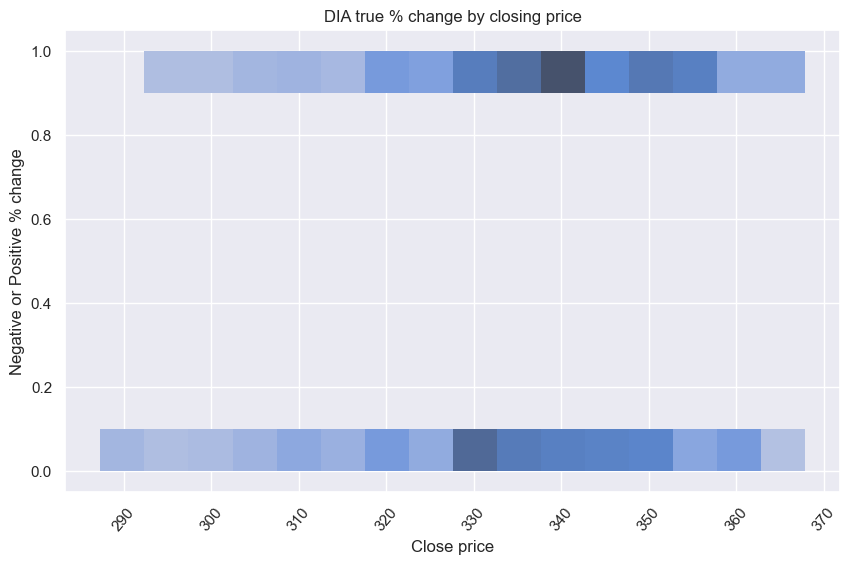

In [77]:
sns.set(rc={'figure.figsize':(10, 6)})
sns.histplot(x=dia_df['DIA - 1week_close'], y=np.array(y_test).flatten())

plt.title(f'{stock} true % change by closing price')
plt.xlabel('Close price')
plt.ylabel('Negative or Positive % change')

plt.xticks(rotation=50)
plt.show()

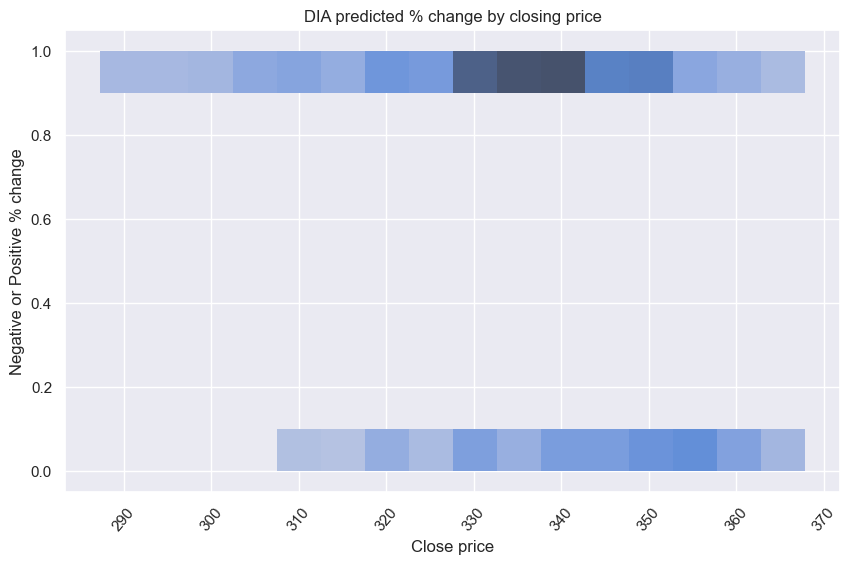

In [78]:
sns.set(rc={'figure.figsize':(10, 6)})
sns.histplot(x=dia_df['DIA - 1week_close'], y=y_pred)

plt.title(f'{stock} predicted % change by closing price')
plt.xlabel('Close price')
plt.ylabel('Negative or Positive % change')

plt.xticks(rotation=50)
plt.show()

## Prophet

Transform the dataset into a time-series modleing dataset:
- Prophet requires at least 2 columns as inputs (**`ds`** column and **`y`** column)
- **`ds`** has the time info: Currently, we have the `Date` as the `Index`, so we reset the *Index* and rename `Date` to `ds`.
- **`y`** has the time-series values: In this example, b/c we are predicting the DJIA and MCD closing prices, the column name `Close DJI` and `Close MCD` are changed to `y`.
- There is no pre-defined name for the additional predictor in Prophet, so we can keep the name `Close VTI`, `RSI DJI`, `EMA DJI`, `VWAP DJI` as they are.

In [79]:
stock = 'DIA'

target = [f'{stock} - 1week_close']
numerical_fts = [f'{stock} - Days_till_div', f'{stock} - Close', f'{stock} - Volume', f'{stock} - RSI5', f'{stock} - RSI14', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50', f'{stock} - MACD', f'{stock} - MACD_signal', f'{stock} - VWAP']
all_fts = ['Day', 'Month', 'Year', 'Date'] + numerical_fts + target

In [80]:
training_df = df.drop(df[df['Date'] >= train_end_date].index)
testing_df = df.drop(df[df['Date'] < train_end_date].index)

In [81]:
training_df_dia = training_df[all_fts]
testing_df_dia = testing_df[all_fts]
training_df_dia = training_df.rename(columns={'Date': 'ds', f'{stock} - 1week_close': 'y'})
testing_df_dia = testing_df.rename(columns={'Date': 'ds', f'{stock} - 1week_close': 'y'})

cols_to_check = [f'{stock} - EMA50']
training_df_dia = training_df_dia.dropna(subset=cols_to_check)
testing_df_dia = testing_df_dia.dropna(subset=cols_to_check)

### Baseline prophet

In [82]:
def fit_and_predict_prophet(train, periods):

    # Fit Prophet model and make predictions for each training DataFrame
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    return model, forecast

In [83]:
# Call the function to get the models and forecasts
periods = 5
model_baseline_dia, forecast_baseline_dia = fit_and_predict_prophet(training_df_dia, periods)

18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
stock = 'MCD'

target = [f'{stock} - 1week_close']
numerical_fts = [f'{stock} - Days_till_div', f'{stock} - Close', f'{stock} - Volume', f'{stock} - RSI5', f'{stock} - RSI14', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50', f'{stock} - MACD', f'{stock} - MACD_signal', f'{stock} - VWAP']
all_fts = ['Day', 'Month', 'Year', 'Date'] + numerical_fts + target

In [85]:
training_df_mcd = df.drop(df[df['Date'] >= train_end_date].index)
testing_df_mcd = df.drop(df[df['Date'] < train_end_date].index)

In [86]:
training_df_mcd = training_df[all_fts]
testing_df_mcd = testing_df[all_fts]
training_df_mcd = training_df.rename(columns={'Date': 'ds', f'{stock} - 1week_close': 'y'})
testing_df_mcd = testing_df.rename(columns={'Date': 'ds', f'{stock} - 1week_close': 'y'})

cols_to_check = [f'{stock} - EMA50']
training_df_mcd = training_df_mcd.dropna(subset=cols_to_check)
testing_df_mcd = testing_df_mcd.dropna(subset=cols_to_check)

In [87]:
# Call the function to get the models and forecasts
periods = 5
model_baseline_mcd, forecast_baseline_mcd = fit_and_predict_prophet(training_df_mcd, periods)

18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing


### Prophet with seasonality

In [88]:
def fit_and_predict_prophet_season(train, periods):

    # Fit Prophet model and make predictions for each training DataFrame
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    return model, forecast

In [89]:
# Call the function to get the models and forecasts
# periods = 16
model_season_dia, forecast_season_dia = fit_and_predict_prophet_season(training_df_dia, periods)
model_season_mcd, forecast_season_mcd = fit_and_predict_prophet_season(training_df_mcd, periods)

18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing


### Mulivariate prophet

In [90]:
# Add seasonality
model_multivariate_dia = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate_dia.add_regressor('DIA - EMA5', standardize=False)
model_multivariate_dia.add_regressor('DIA - EMA15', standardize=False)
model_multivariate_dia.add_regressor('DIA - VWAP', standardize=False)
model_multivariate_dia.add_regressor('DIA - RSI5', standardize=False)
model_multivariate_dia.add_regressor('DIA - RSI14', standardize=False)

# Fit the model on the training dataset
model_multivariate_dia.fit(training_df_dia)
future_multivariate_dia = model_multivariate_dia.make_future_dataframe(periods=periods)
future_multivariate_dia = pd.merge(future_multivariate_dia, testing_df_dia[['ds', 'DIA - EMA5', 'DIA - EMA15', 'DIA - VWAP', 'DIA - RSI5', 'DIA - RSI14']], on='ds', how='inner')
forecast_multivariate_dia = model_multivariate_dia.predict(future_multivariate_dia)

18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
# Add seasonality
model_multivariate_mcd = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate_mcd.add_regressor('MCD - EMA5', standardize=False)
model_multivariate_mcd.add_regressor('MCD - EMA15', standardize=False)
model_multivariate_mcd.add_regressor('MCD - VWAP', standardize=False)
model_multivariate_mcd.add_regressor('MCD - RSI5', standardize=False)
model_multivariate_mcd.add_regressor('MCD - RSI14', standardize=False)

# Fit the model on the training dataset
model_multivariate_mcd.fit(training_df_mcd)
future_multivariate_mcd = model_multivariate_mcd.make_future_dataframe(periods=periods)
future_multivariate_mcd = pd.merge(future_multivariate_mcd, testing_df_dia[['ds', 'MCD - EMA5', 'MCD - EMA15', 'MCD - VWAP', 'MCD - RSI5', 'MCD - RSI14']], on='ds', how='inner')
forecast_multivariate_mcd = model_multivariate_mcd.predict(future_multivariate_mcd)

18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing


# Evaluation

## Classification

In [120]:
metrics_df.round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
0,LSTM,DIA,0.546,0.563,0.916,0.0,0.445
1,DT,DIA,0.565,0.570,0.965,0.71634,0.501
2,GBT,DIA,0.566,0.571,0.960,0.715693,0.503
3,RF,DIA,0.492,0.665,0.217,0.326693,0.536
4,SVM,DIA,0.569,0.569,1.000,0.725415,0.500
5,DT,All,0.696,0.724,0.728,0.725964,0.692
6,GBT,All,0.575,0.576,0.880,0.695931,0.539
7,RF,All,0.805,0.808,0.850,0.828489,0.800
8,SVM,All,0.553,0.553,1.000,0.712137,0.500
9,RF,DIA,0.557,0.555,0.734,0.631933,0.550


In [93]:
metrics_df[metrics_df['Model'] == 'DT'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
1,DT,DIA,0.565,0.570,0.965,0.71634,0.501
5,DT,All,0.696,0.724,0.728,0.725964,0.692


In [94]:
metrics_df[metrics_df['Model'] == 'GBT'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
2,GBT,DIA,0.566,0.571,0.96,0.715693,0.503
6,GBT,All,0.575,0.576,0.88,0.695931,0.539


In [95]:
metrics_df[metrics_df['Model'] == 'RF'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
3,RF,DIA,0.492,0.665,0.217,0.326693,0.536
7,RF,All,0.805,0.808,0.850,0.828489,0.800
9,RF,DIA,0.557,0.555,0.734,0.631933,0.550


In [96]:
metrics_df[metrics_df['Model'] == 'SVM'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
4,SVM,DIA,0.569,0.569,1.0,0.725415,0.5
8,SVM,All,0.553,0.553,1.0,0.712137,0.5


## Regression

After making the prediction on the future df, we can plot the results

---

using `.plot`:
- **Black dots**: are the actual values.
- **Blue line**: is the PREDICTION.
- **Blue shade**: shows the uncertainty interval. (Default value for uncertainty is 80%, used here!)

The *uncertainty interval* is calcualted based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals.

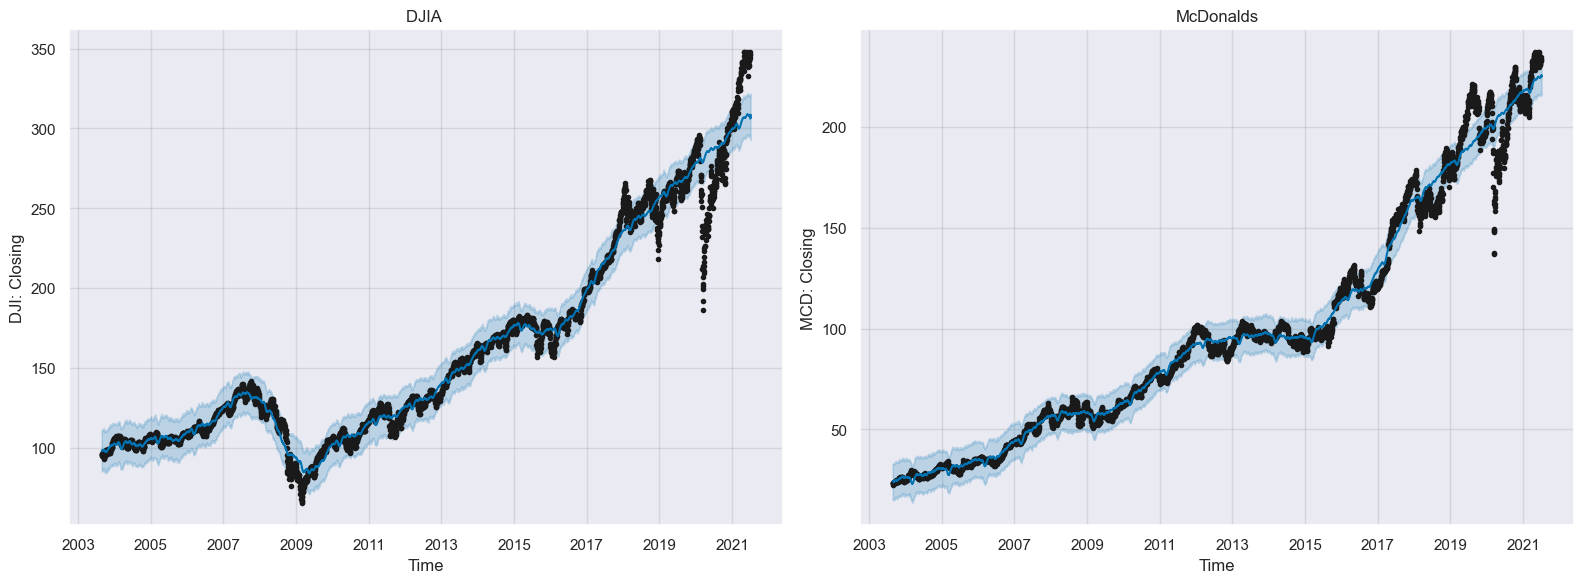

In [97]:
x = mdates.date2num(df['Date'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_baseline_dia.plot(forecast_baseline_dia, ax=axes[0])
axes[0].set_ylabel('DJI: Closing')
axes[0].set_xlabel('Time')
axes[0].set_title('DJIA ');

model_baseline_mcd.plot(forecast_baseline_mcd, ax=axes[1])
axes[1].set_ylabel('MCD: Closing')
axes[1].set_title('McDonalds');
axes[1].set_xlabel('Time')


# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

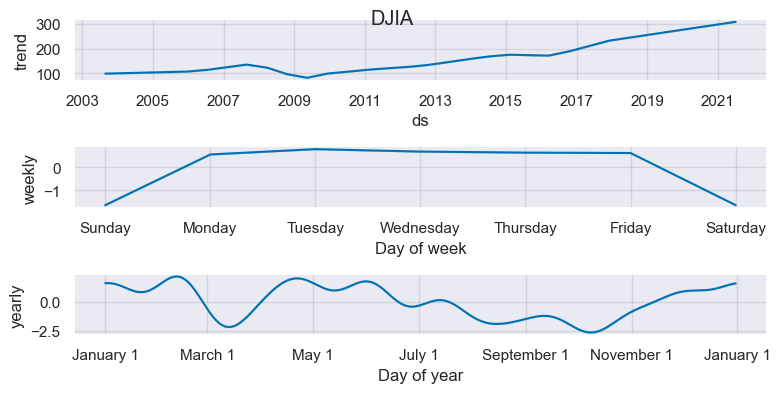

In [98]:
# Visualize the forecast components
fig = model_baseline_dia.plot_components(forecast_baseline_dia, figsize=(8, 4));
plt.suptitle('DJIA');

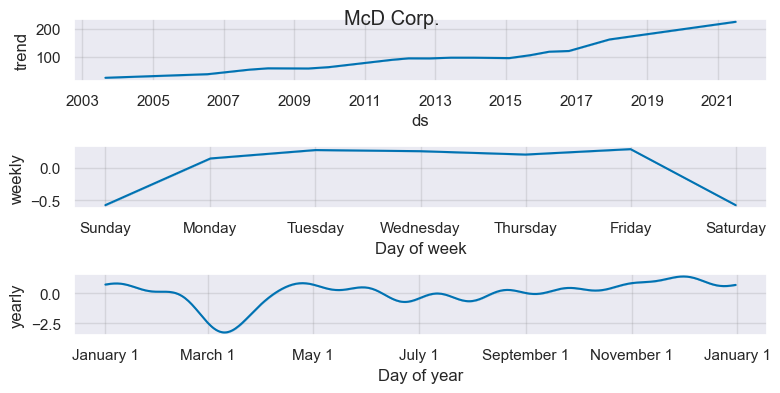

In [99]:
# Visualize the forecast components
fig = model_baseline_mcd.plot_components(forecast_baseline_mcd, figsize=(8, 4));
plt.suptitle('McD Corp.');

In [100]:
# Merge actual and predicted values
performance_baseline_dia = pd.merge(testing_df_dia, forecast_baseline_dia[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_baseline_dia_MAE = mean_absolute_error(performance_baseline_dia['y'], performance_baseline_dia['yhat'])
print(f'The MAE for the DJIA baseline model is USD {round(performance_baseline_dia_MAE)}')

# Check MAPE value
performance_baseline_dia_MAPE = mape_calc(performance_baseline_dia['y'], performance_baseline_dia['yhat'])
print(f'The MAPE for the DJIA baseline model is {round(performance_baseline_dia_MAPE,3)}')

The MAE for the DJIA baseline model is USD 41
The MAPE for the DJIA baseline model is 0.118


**Obs: DJIA**
- The MAE (Mean Abs Error) for the BASELINE model is USD 41, meaning that on avg, the forecast is off by USD 41. Given the DJIA price of nearly USD 350, the prediction is not bad.
- The MAPE (Mean Abs Percent Error) for the BASELINE model is 12%, meaning that on avg, the forecast is off by 12% of the stock price.

In [101]:
# Merge actual and predicted values
performance_baseline_mcd = pd.merge(testing_df_mcd, forecast_baseline_mcd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_baseline_mcd_MAE = mean_absolute_error(performance_baseline_mcd['y'], performance_baseline_mcd['yhat'])
print(f'The MAE for the MCD baseline model is USD {round(performance_baseline_mcd_MAE)}')

# Check MAPE value
performance_baseline_mcd_MAPE = mape_calc(performance_baseline_mcd['y'], performance_baseline_mcd['yhat'])
print(f'The MAPE for the MCD baseline model is {round(performance_baseline_mcd_MAPE,3)}')

The MAE for the MCD baseline model is USD 10
The MAPE for the MCD baseline model is 0.044


**Obs: MCD**
- The MAE (Mean Abs Error) for the BASELINE model is USD 10, meaning that on avg, the forecast is off by USD 10. Given the MCD price of nearly USD 290, the prediction is not bad.
- The MAPE (Mean Abs Percent Error) for the BASELINE model is 4.4%, meaning that on avg, the forecast is off by 4.4% of the stock price.

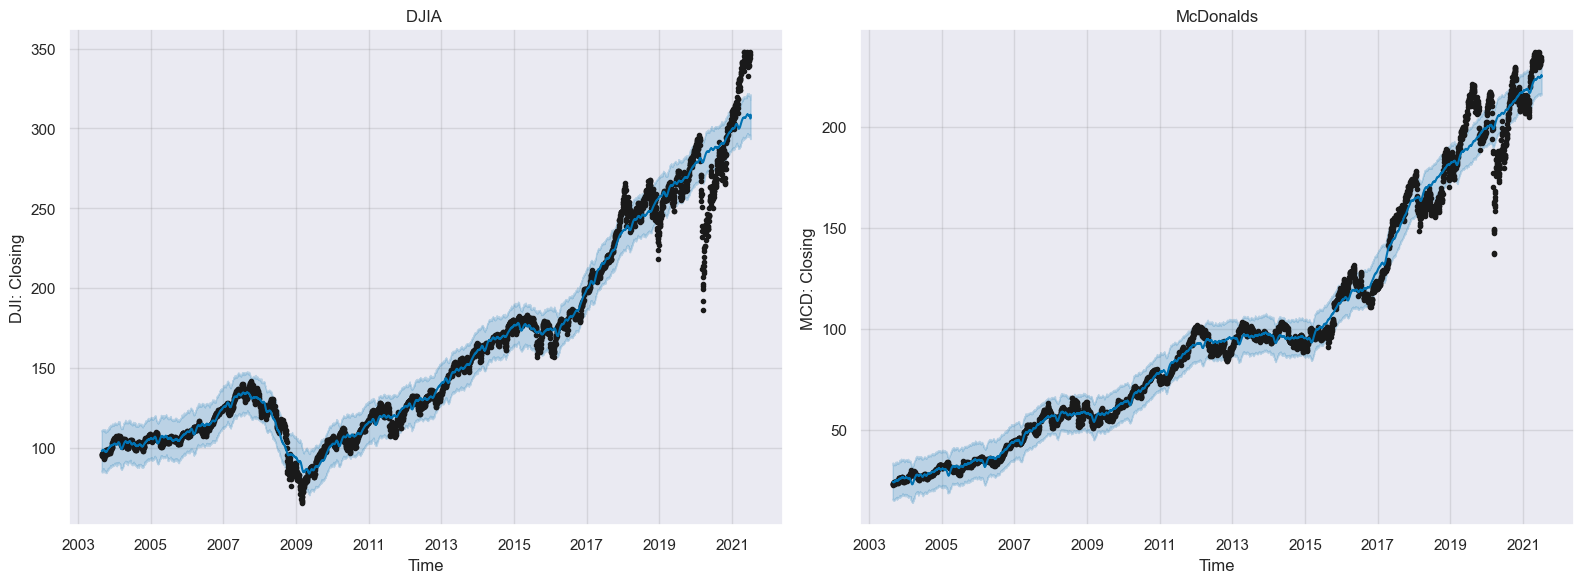

In [102]:
x = mdates.date2num(df['Date'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_season_dia.plot(forecast_season_dia, ax=axes[0])
axes[0].set_ylabel('DJI: Closing')
axes[0].set_xlabel('Time')
axes[0].set_title('DJIA ');

model_season_mcd.plot(forecast_season_mcd, ax=axes[1])
axes[1].set_ylabel('MCD: Closing')
axes[1].set_title('McDonalds');
axes[1].set_xlabel('Time')


# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

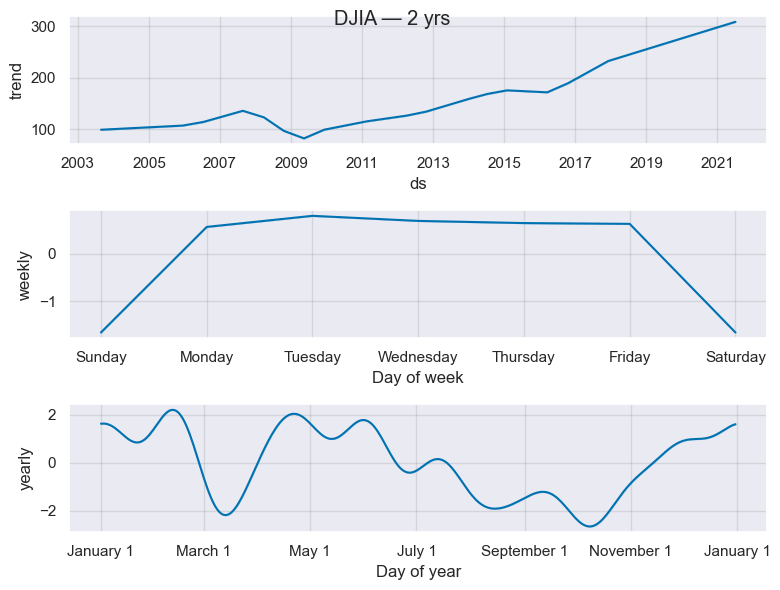

In [103]:
# Visualize the forecast components
fig = model_season_dia.plot_components(forecast_season_dia, figsize=(8, 6));
plt.suptitle('DJIA — 2 yrs');

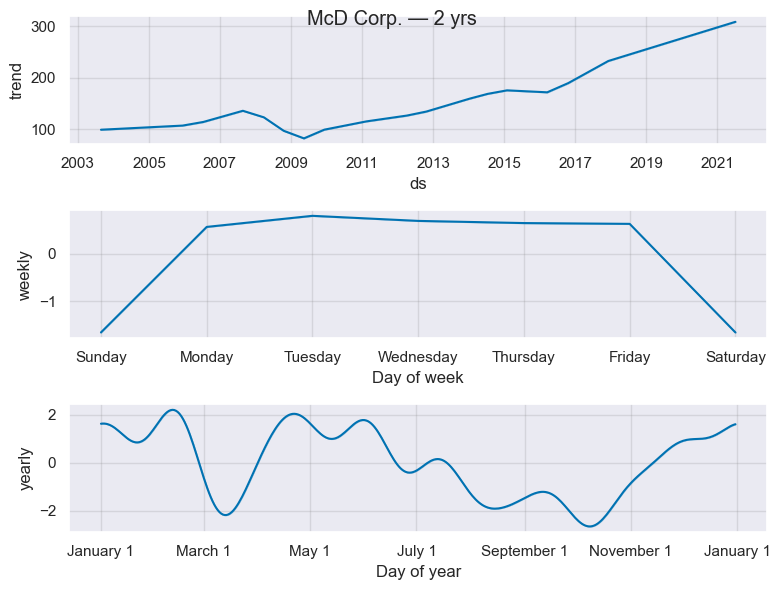

In [104]:
# Visualize the forecast components
fig = model_season_dia.plot_components(forecast_season_dia, figsize=(8, 6));
plt.suptitle('McD Corp. — 2 yrs');

In [105]:
# Merge actual and predicted values
performance_season_dia = pd.merge(testing_df_dia, forecast_season_dia[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_season_dia_MAE = mean_absolute_error(performance_season_dia['y'], performance_season_dia['yhat'])
print(f'The MAE for the DJIA seasonality model is USD {round(performance_season_dia_MAE)}')

# Check MAPE value
performance_season_dia_MAPE = mape_calc(performance_season_dia['y'], performance_season_dia['yhat'])
print(f'The MAPE for the DJIA seasonality model is {round(performance_season_dia_MAPE,3)}')

The MAE for the DJIA seasonality model is USD 41
The MAPE for the DJIA seasonality model is 0.118


In [106]:
# Merge actual and predicted values
performance_season_mcd = pd.merge(testing_df_mcd, forecast_season_mcd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_season_mcd_MAE = mean_absolute_error(performance_season_mcd['y'], performance_season_mcd['yhat'])
print(f'The MAE for the MCD seasonality model is USD {round(performance_season_mcd_MAE)}')

# Check MAPE value
performance_season_mcd_MAPE = mape_calc(performance_season_mcd['y'], performance_season_mcd['yhat'])
print(f'The MAPE for the MCD seasonality model is {round(performance_season_mcd_MAPE,3)}')

The MAE for the MCD seasonality model is USD 10
The MAPE for the MCD seasonality model is 0.044


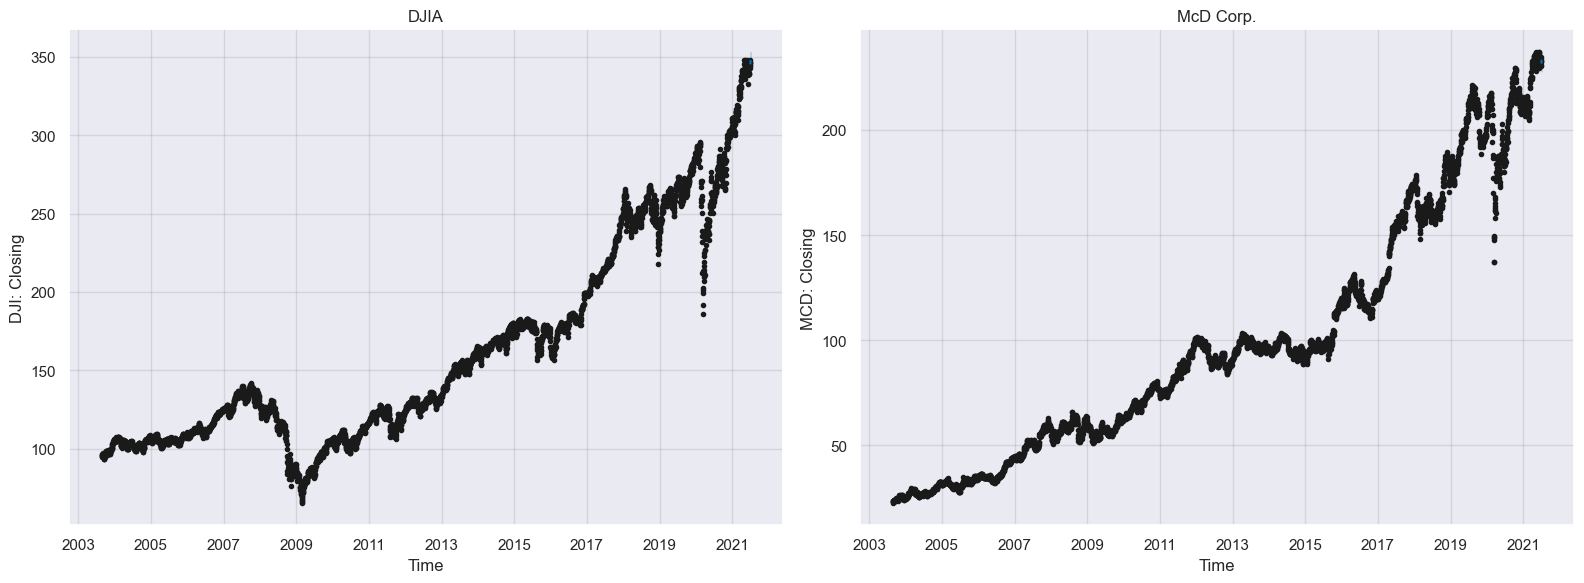

In [107]:
# Plot the predictions
fig, axes = plt.subplots(1, 2, figsize=(8*2, 6))  # Adjust the figure size as needed

# Plot the prediction for each DataFrame
model_multivariate_dia.plot(forecast_multivariate_dia, ax=axes[0])
axes[0].set_ylabel('DJI: Closing')
axes[0].set_xlabel('Time')
axes[0].set_title('DJIA');

model_multivariate_mcd.plot(forecast_multivariate_mcd, ax=axes[1])
axes[1].set_ylabel('MCD: Closing')
axes[1].set_title('McD Corp.');
axes[1].set_xlabel('Time')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

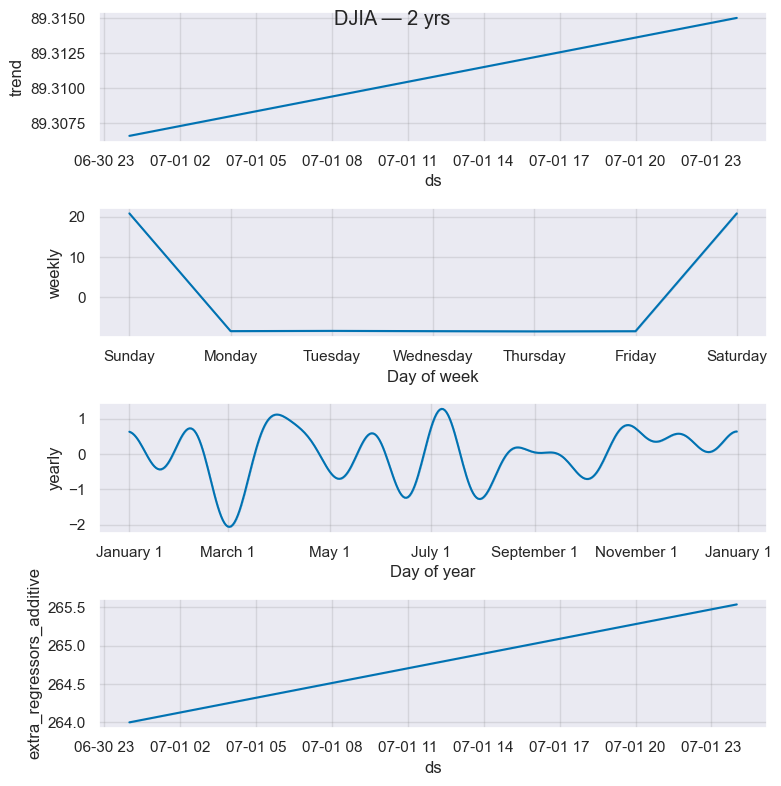

In [108]:
# Visualize the forecast components
fig = model_multivariate_dia.plot_components(forecast_multivariate_dia, figsize=(8, 8));
plt.suptitle('DJIA — 2 yrs');

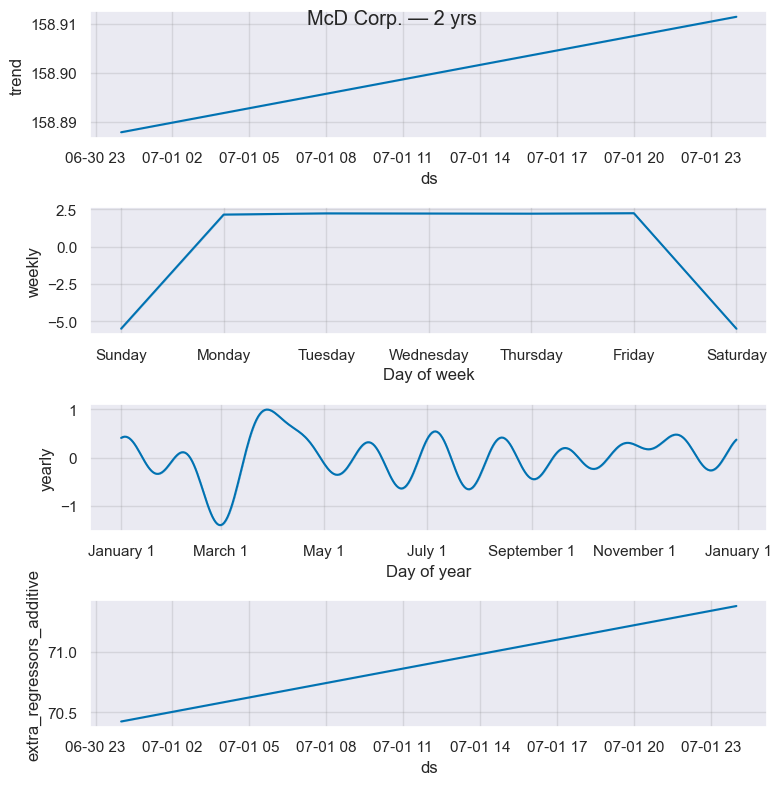

In [109]:
# Visualize the forecast components
fig = model_multivariate_mcd.plot_components(forecast_multivariate_mcd, figsize=(8, 8));
plt.suptitle('McD Corp. — 2 yrs');

In [110]:
# Merge actual and predicted values
performance_multivariate_dia = pd.merge(testing_df_dia, forecast_multivariate_dia[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_multivariate_dia_MAE = mean_absolute_error(performance_multivariate_dia['y'], performance_multivariate_dia['yhat'])
print(f'The MAE for the DJIA multivariate model is USD {round(performance_multivariate_dia_MAE)}')

# Check MAPE value
performance_multivariate_dia_MAPE = mape_calc(performance_multivariate_dia['y'], performance_multivariate_dia['yhat'])
print(f'The MAPE for the DJIA multivariate model is {round(performance_multivariate_dia_MAPE,3)}')

The MAE for the DJIA multivariate model is USD 3
The MAPE for the DJIA multivariate model is 0.008


**Obs: DJIA** The multivariate model performance is much better than the previous univariate seasonality model (w/o the regressors)...   
- The MAE (Mean Abs Error) for the multivariate model decreased to USD 3 (compared to the seasonality model USD 41).
- The MAPE (Mean Abs Percent Error) for the multivariate model also decreased to 0.8% (compared to the seasonality model 12%).

In [111]:
# Merge actual and predicted values
performance_multivariate_mcd = pd.merge(testing_df_mcd, forecast_multivariate_mcd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:],on='ds')

# check MAE value
performance_multivariate_mcd_MAE = mean_absolute_error(performance_multivariate_mcd['y'], performance_multivariate_mcd['yhat'])
print(f'The MAE for the MCD multivariate model is USD {round(performance_multivariate_mcd_MAE)}')

# Check MAPE value
performance_multivariate_mcd_MAPE = mape_calc(performance_multivariate_mcd['y'], performance_multivariate_mcd['yhat'])
print(f'The MAPE for the MCD multivariate model is {round(performance_multivariate_mcd_MAPE,3)}')

The MAE for the MCD multivariate model is USD 3
The MAPE for the MCD multivariate model is 0.014


**Obs: MCD** The multivariate model performance is much better than the previous univariate seasonality model (w/o the regressors)...
- The MAE (Mean Abs Error) for the multivariate model decreased to USD 3 (compared to the seasonality model USD 10).
- The MAPE (Mean Abs Percent Error) for the multivariate model also decreased to 1.4% (compared to the seasonality model 4.4%).

## Discussion and conclusions

Based on the results of the prophet model and ensemble tree methods, random forests, it certainly seems plausible for AI and machine learning prediction of the stock market. While these methods are not able to capture all variance which occurs in the stock market, they are only trained on historical stock market data. Significant improvements could be made to these models through addition of other models such as AI sentiment analysis of public opinion and news events on a local and global scale. As these external events have such a signficant impact on overall economic and market sentiment, it is likely that adding them to these existing price models could be part of a highly predictive trading algorithm.  
However, the influence of external events on the stock market can not be treated trivially. While sentiment analysis could help guide and predict market trends, the market is not fully predictable, no matter how much information is gathered. While similar models are certainly already in play at large investment firms and hedge funds who have extensive capital available for trading, using these models without further testing on live stock market data would be unwise.  
In conclusion, the random forest classifier and prophet regression model both show extreme promise for machine learning stock portfolio management, being able to reliably predict market trends. Further research should be turned to deploying these models in testing environments, running live stock data, increasing model accuracy through additional feature inclusion, including company demographics and sentiment analysis of the broader economic market.  
There are no conflicts of interest or biases within the authors of this project.